# Pipeline Completo: Modelo de IA para Optimizar Ratio de Sharpe

Este notebook ejecuta todo el proceso desde la descarga de datos hasta el backtesting final.

## Pasos:
1. Descargar datos de ETFs (20 años)
2. Generar features de Machine Learning
3. Entrenar modelos de predicción
4. Optimizar portafolio
5. Backtesting del sistema completo
6. Visualizaciones de resultados

## Paso 1: Instalación de Dependencias

In [6]:
# Instalar dependencias si es necesario
# Descomenta la siguiente línea si necesitas instalar paquetes
# !pip install -r requirements.txt

## Paso 2: Importar Librerías

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import warnings
import sys
warnings.filterwarnings('ignore')

# Configurar estilo de gráficos
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('ggplot')
sns.set_palette("husl")

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


## Paso 3: Descargar Datos de ETFs

In [8]:
# ============================================================================# PASO 3: DESCARGAR DATOS DE ETFs# ============================================================================# Este paso descarga datos históricos de ETFs desde Yahoo Finance y calcula retornos diarios.# El código está integrado directamente en el notebook para mayor claridad."""Script para descargar datos de ETFs de Yahoo Finance y calcular retornos diarios.Cubre 14 ETFs que representan diferentes regiones y sectores del mundo."""import yfinance as yfimport pandas as pdimport numpy as npfrom datetime import datetime, timedeltaimport osimport matplotlib.pyplot as pltimport seaborn as snsfrom scipy import statsfrom statsmodels.tsa.stattools import adfuller, kpssfrom statsmodels.stats.diagnostic import acorr_ljungboxfrom statsmodels.tsa.stattools import acf, pacffrom statsmodels.regression.linear_model import OLSfrom statsmodels.stats.stattools import durbin_watsonimport warningswarnings.filterwarnings('ignore')# Configurar estilo de gráficostry:    plt.style.use('seaborn-v0_8-darkgrid')except:    try:        plt.style.use('seaborn-darkgrid')    except:        plt.style.use('ggplot')sns.set_palette("husl")# Definir los ETFs seleccionados (cubren diferentes regiones, bonos y materias primas)ETFS = {    # ACCIONES - EEUU    'SPY': 'S&P 500 (EEUU)',    'QQQ': 'Nasdaq 100 (Tecnología EEUU)',    'IWM': 'Russell 2000 (Pequeñas Empresas EEUU)',    # ACCIONES - Internacional    'EFA': 'EAFE - Europa, Asia, Lejano Oriente',    'EEM': 'Mercados Emergentes',    'VGK': 'Europa (Vanguard)',    'VPL': 'Asia-Pacífico (Vanguard)',    # BONOS    'LQD': 'Bonos Corporativos Investment Grade',    'HYG': 'Bonos High Yield (Basura)',    'TLT': 'Bonos del Tesoro EEUU 20+ años',    'AGG': 'Total Bond Market (Bonos Agregados)',    # TASA LIBRE DE RIESGO (RF)    'SHY': 'Tasa Libre de Riesgo - Treasury 1-3 años (iShares)',    # Alternativa: 'BIL': 'Tasa Libre de Riesgo - T-Bill 1-3 meses (SPDR)'    # MATERIAS PRIMAS    'GLD': 'Oro (SPDR Gold Trust)',    'SLV': 'Plata (iShares Silver Trust)',    'USO': 'Petróleo (United States Oil Fund)',    'DJP': 'Bloomberg Commodity Index (iPath)',    # REAL ESTATE    'VNQ': 'REITs EEUU (Vanguard Real Estate ETF)'}def download_etf_returns(etf_symbols, years=10):    """    Descarga datos históricos de ETFs y calcula retornos diarios.        Si un ETF no tiene datos para el período completo, intenta descargar    todos los datos disponibles desde su fecha de lanzamiento.        Parameters:    -----------    etf_symbols : dict        Diccionario con símbolos de ETFs y sus descripciones    years : int        Número de años de datos históricos a descargar (default: 10)        Returns:    --------    dict        Diccionario con nombre del ETF y sus retornos diarios    """    # Calcular fecha de inicio (hace 'years' años)    end_date = datetime.now()    start_date = end_date - timedelta(days=years * 365)        returns_dict = {}    failed_etfs = []    partial_etfs = []  # ETFs con datos pero menos del período solicitado        print(f"Descargando datos de {len(etf_symbols)} ETFs desde {start_date.date()} hasta {end_date.date()}...")    print("-" * 80)        for symbol, description in etf_symbols.items():        try:            print(f"Descargando {symbol} - {description}...")                        # Descargar datos históricos            ticker = yf.Ticker(symbol)            data = ticker.history(start=start_date, end=end_date)                        # Si no hay datos, intentar descargar todos los datos disponibles            if data.empty:                print(f"  [INFO] No hay datos para el período solicitado, intentando descargar todos los datos disponibles...")                # Intentar desde una fecha muy antigua (1980)                fallback_start = datetime(1980, 1, 1)                data = ticker.history(start=fallback_start, end=end_date)                                if data.empty:                    print(f"  [WARNING] No se encontraron datos para {symbol} en ningún período")                    failed_etfs.append(symbol)                    continue                        # Calcular retornos diarios (porcentaje)            # Retorno = (Precio_t - Precio_{t-1}) / Precio_{t-1} * 100            data['Returns'] = data['Close'].pct_change() * 100                        # Eliminar el primer valor (NaN)            returns = data['Returns'].dropna()                        # Verificar si tiene menos datos de los solicitados            actual_years = (returns.index[-1] - returns.index[0]).days / 365.25            if actual_years < years * 0.8:  # Menos del 80% del período solicitado                partial_etfs.append({                    'symbol': symbol,                    'years': actual_years,                    'requested': years                })                        # Guardar en el diccionario            returns_dict[symbol] = returns                        # Mostrar información detallada            print(f"  [OK] {symbol}: {len(returns):,} días de retornos calculados")            print(f"    Período: {returns.index[0].date()} a {returns.index[-1].date()}")            print(f"    Años disponibles: {actual_years:.1f} años (solicitados: {years} años)")            print(f"    Retorno promedio diario: {returns.mean():.4f}%")            print(f"    Volatilidad diaria: {returns.std():.4f}%")                        if actual_years < years * 0.8:                print(f"    [NOTA] Este ETF tiene menos datos de los solicitados")            print()                    except Exception as e:            print(f"  [ERROR] Error descargando {symbol}: {str(e)}")            failed_etfs.append(symbol)            print()        # Resumen final    print("-" * 80)    print(f"[OK] Proceso completado.")    print(f"  ETFs descargados exitosamente: {len(returns_dict)}/{len(etf_symbols)}")        if partial_etfs:        print(f"\n  ETFs con datos parciales ({len(partial_etfs)}):")        for etf_info in partial_etfs:            print(f"    - {etf_info['symbol']}: {etf_info['years']:.1f} años (solicitados: {etf_info['requested']} años)")        if failed_etfs:        print(f"\n  ETFs que no se pudieron descargar ({len(failed_etfs)}):")        for symbol in failed_etfs:            print(f"    - {symbol}")        print(f"\n  [WARNING] Estos ETFs no estarán disponibles en el análisis.")        print("-" * 80)        return returns_dictdef calculate_excess_returns(returns_dict, rf_symbol='SHY'):    """    Calcula retornos en exceso (excess returns) restando la tasa libre de riesgo.        Parameters:    -----------    returns_dict : dict        Diccionario con retornos de ETFs    rf_symbol : str        Símbolo del ETF a usar como tasa libre de riesgo (default: 'SHY')        Returns:    --------    dict        Diccionario con retornos en exceso para cada ETF    """    if rf_symbol not in returns_dict:        print(f"[WARNING]  {rf_symbol} no encontrado en returns_dict. No se calcularán retornos en exceso.")        return None        rf_returns = returns_dict[rf_symbol]    excess_returns_dict = {}        print(f"\nCalculando retornos en exceso usando {rf_symbol} como tasa libre de riesgo...")        for symbol, returns in returns_dict.items():        if symbol == rf_symbol:            continue  # No calcular exceso para el propio RF                # Alinear fechas        aligned_data = pd.DataFrame({            'asset': returns,            'rf': rf_returns        }).dropna()                if len(aligned_data) > 0:            excess_returns = aligned_data['asset'] - aligned_data['rf']            excess_returns_dict[symbol] = excess_returns            print(f"  [OK] {symbol}: {len(excess_returns)} observaciones")        return excess_returns_dictdef save_returns_to_dict_file(returns_dict, data_dir='data', filename='etf_returns_dict.pkl'):    """    Guarda el diccionario de retornos en un archivo pickle.        Parameters:    -----------    returns_dict : dict        Diccionario con retornos de ETFs    data_dir : str        Directorio donde guardar los archivos    filename : str        Nombre del archivo donde guardar    """    import pickle        # Crear directorio si no existe    os.makedirs(data_dir, exist_ok=True)        filepath = os.path.join(data_dir, filename)    with open(filepath, 'wb') as f:        pickle.dump(returns_dict, f)    print(f"\n[OK] Diccionario guardado en {filepath}")def plot_all_etfs_comparison(returns_dict, data_dir='data'):    """    Crea gráficos comparativos de todos los ETFs.        Parameters:    -----------    returns_dict : dict        Diccionario con retornos de ETFs    data_dir : str        Directorio donde guardar los gráficos    """    # Crear directorio si no existe    os.makedirs(data_dir, exist_ok=True)        # Convertir diccionario a DataFrame para facilitar el análisis    returns_df = pd.DataFrame(returns_dict)        # Alinear fechas (usar intersección de fechas comunes)    returns_df = returns_df.dropna()        print("\n" + "=" * 80)    print("GENERANDO GRÁFICOS COMPARATIVOS")    print("=" * 80)        # 1. Gráfico 1: Series temporales de retornos acumulados    print("\n1. Generando gráfico de retornos acumulados...")    fig, ax = plt.subplots(figsize=(14, 8))        # Calcular retornos acumulados (normalizados a 100)    cumulative_returns = (1 + returns_df / 100).cumprod() * 100        for col in cumulative_returns.columns:        ax.plot(cumulative_returns.index, cumulative_returns[col],                 label=col, linewidth=1.5, alpha=0.8)        ax.set_title('Retornos Acumulados de ETFs (Base 100)', fontsize=16, fontweight='bold')    ax.set_xlabel('Fecha', fontsize=12)    ax.set_ylabel('Valor Acumulado (Base 100)', fontsize=12)    ax.legend(loc='best', ncol=2, fontsize=9)    ax.grid(True, alpha=0.3)    plt.tight_layout()        filepath = os.path.join(data_dir, '1_retornos_acumulados.png')    plt.savefig(filepath, dpi=300, bbox_inches='tight')    print(f"   [OK] Guardado: {filepath}")    plt.close()        # 2. Gráfico 2: Matriz de correlación    print("2. Generando matriz de correlación...")    fig, ax = plt.subplots(figsize=(12, 10))        correlation_matrix = returns_df.corr()        sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',                 center=0, vmin=-1, vmax=1, square=True,                 linewidths=0.5, cbar_kws={"shrink": 0.8}, ax=ax)        ax.set_title('Matriz de Correlación entre ETFs', fontsize=16, fontweight='bold', pad=20)    plt.tight_layout()        filepath = os.path.join(data_dir, '2_matriz_correlacion.png')    plt.savefig(filepath, dpi=300, bbox_inches='tight')    print(f"   [OK] Guardado: {filepath}")    plt.close()        # 3. Gráfico 3: Distribución de retornos (boxplot)    print("3. Generando boxplot de distribuciones...")    fig, ax = plt.subplots(figsize=(14, 8))        returns_df_melted = returns_df.melt(var_name='ETF', value_name='Retorno')    sns.boxplot(data=returns_df_melted, x='ETF', y='Retorno', ax=ax)        ax.set_title('Distribución de Retornos Diarios por ETF', fontsize=16, fontweight='bold')    ax.set_xlabel('ETF', fontsize=12)    ax.set_ylabel('Retorno Diario (%)', fontsize=12)    ax.tick_params(axis='x', rotation=45)    ax.grid(True, alpha=0.3, axis='y')    plt.tight_layout()        filepath = os.path.join(data_dir, '3_distribucion_retornos.png')    plt.savefig(filepath, dpi=300, bbox_inches='tight')    print(f"   [OK] Guardado: {filepath}")    plt.close()        # 4. Gráfico 4: Scatter plots de todos contra todos (matriz de dispersión)    print("4. Generando matriz de scatter plots...")    fig = sns.pairplot(returns_df, diag_kind='kde', plot_kws={'alpha': 0.3, 's': 10})    fig.fig.suptitle('Matriz de Scatter Plots: Retornos Diarios entre ETFs',                      fontsize=16, fontweight='bold', y=1.02)        filepath = os.path.join(data_dir, '4_matriz_scatter.png')    plt.savefig(filepath, dpi=300, bbox_inches='tight')    print(f"   [OK] Guardado: {filepath}")    plt.close()        # 5. Gráfico 5: Retorno vs Volatilidad (Risk-Return)    print("5. Generando gráfico Risk-Return...")    fig, ax = plt.subplots(figsize=(12, 8))        # Calcular estadísticas anualizadas    # Los retornos están en porcentaje, primero convertir a decimales    returns_decimal = returns_df / 100    annual_returns = returns_decimal.mean() * 252 * 100  # Retorno anualizado (%)    annual_vol = returns_decimal.std() * np.sqrt(252) * 100  # Volatilidad anualizada (%)        scatter = ax.scatter(annual_vol, annual_returns, s=200, alpha=0.6,                         c=range(len(annual_returns)), cmap='viridis')        # Etiquetar cada punto    # IMPORTANTE: usar las etiquetas del índice (símbolos), no índices enteros    for symbol in annual_returns.index:        ax.annotate(            symbol,            (annual_vol.loc[symbol], annual_returns.loc[symbol]),            fontsize=10,            ha='center',            va='bottom',            fontweight='bold'        )        ax.set_xlabel('Volatilidad Anualizada (%)', fontsize=12)    ax.set_ylabel('Retorno Anualizado (%)', fontsize=12)    ax.set_title('Risk-Return: Retorno vs Volatilidad Anualizada',                 fontsize=16, fontweight='bold')    ax.grid(True, alpha=0.3)    plt.colorbar(scatter, ax=ax, label='Índice ETF')    plt.tight_layout()        filepath = os.path.join(data_dir, '5_risk_return.png')    plt.savefig(filepath, dpi=300, bbox_inches='tight')    print(f"   [OK] Guardado: {filepath}")    plt.close()        # 6. Gráfico 6: Series temporales de retornos diarios (todas superpuestas)    print("6. Generando series temporales de retornos diarios...")    fig, ax = plt.subplots(figsize=(16, 8))        for col in returns_df.columns:        ax.plot(returns_df.index, returns_df[col], label=col, alpha=0.6, linewidth=0.8)        ax.set_title('Retornos Diarios de Todos los ETFs', fontsize=16, fontweight='bold')    ax.set_xlabel('Fecha', fontsize=12)    ax.set_ylabel('Retorno Diario (%)', fontsize=12)    ax.legend(loc='best', ncol=3, fontsize=8)    ax.grid(True, alpha=0.3)    ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)    plt.tight_layout()        filepath = os.path.join(data_dir, '6_retornos_diarios.png')    plt.savefig(filepath, dpi=300, bbox_inches='tight')    print(f"   [OK] Guardado: {filepath}")    plt.close()        print("\n[OK] Todos los gráficos generados exitosamente en el directorio 'data/'")def analyze_time_series_properties(returns_dict, market_factor='SPY'):    """    Analiza las propiedades estadísticas y de series temporales de cada ETF.        Parameters:    -----------    returns_dict : dict        Diccionario con retornos de ETFs    market_factor : str        Símbolo del ETF a usar como factor de mercado (default: 'SPY')        Returns:    --------    pd.DataFrame        DataFrame con todas las propiedades analizadas para cada ETF    """    print("\n" + "=" * 80)    print("ANÁLISIS DE PROPIEDADES ESTADÍSTICAS Y DE SERIES TEMPORALES")    print("=" * 80)        # Convertir a DataFrame para facilitar cálculos    returns_df = pd.DataFrame(returns_dict)    returns_df = returns_df.dropna()        # Obtener retornos del factor de mercado si existe    market_returns = None    if market_factor in returns_df.columns:        market_returns = returns_df[market_factor]        properties_list = []        for symbol in returns_df.columns:        print(f"\nAnalizando {symbol}...")        returns = returns_df[symbol].dropna()                if len(returns) < 100:  # Necesitamos suficientes datos            print(f"  [WARNING]  Datos insuficientes para {symbol}")            continue                properties = {'ETF': symbol}                # ========== 1. ESTACIONARIEDAD Y RAÍZ UNITARIA ==========        try:            # Test ADF (Augmented Dickey-Fuller)            adf_result = adfuller(returns, autolag='AIC')            properties['adf_statistic'] = adf_result[0]            properties['adf_pvalue'] = adf_result[1]            properties['adf_stationary'] = adf_result[1] < 0.05                        # Test KPSS            try:                kpss_result = kpss(returns, regression='ct', nlags='auto')                properties['kpss_statistic'] = kpss_result[0]                properties['kpss_pvalue'] = kpss_result[1]                properties['kpss_stationary'] = kpss_result[1] > 0.05            except:                properties['kpss_statistic'] = np.nan                properties['kpss_pvalue'] = np.nan                properties['kpss_stationary'] = np.nan        except Exception as e:            print(f"    [WARNING]  Error en tests de estacionariedad: {e}")            properties['adf_statistic'] = np.nan            properties['adf_pvalue'] = np.nan            properties['adf_stationary'] = np.nan            properties['kpss_statistic'] = np.nan            properties['kpss_pvalue'] = np.nan            properties['kpss_stationary'] = np.nan                # ========== 2. AUTOCORRELACIÓN Y AUTOCORRELACIÓN PARCIAL ==========        try:            # ACF y PACF para lags 1, 5, 10, 20            acf_values = acf(returns, nlags=20, fft=True)            pacf_values = pacf(returns, nlags=20)                        properties['acf_lag1'] = acf_values[1] if len(acf_values) > 1 else np.nan            properties['acf_lag5'] = acf_values[5] if len(acf_values) > 5 else np.nan            properties['acf_lag10'] = acf_values[10] if len(acf_values) > 10 else np.nan            properties['acf_lag20'] = acf_values[20] if len(acf_values) > 20 else np.nan                        properties['pacf_lag1'] = pacf_values[1] if len(pacf_values) > 1 else np.nan            properties['pacf_lag5'] = pacf_values[5] if len(pacf_values) > 5 else np.nan            properties['pacf_lag10'] = pacf_values[10] if len(pacf_values) > 10 else np.nan            properties['pacf_lag20'] = pacf_values[20] if len(pacf_values) > 20 else np.nan                        # Test de Ljung-Box para autocorrelación serial            try:                lb_result = acorr_ljungbox(returns, lags=10, return_df=True)                properties['ljung_box_pvalue'] = lb_result['lb_pvalue'].iloc[-1]                properties['has_autocorrelation'] = lb_result['lb_pvalue'].iloc[-1] < 0.05            except:                properties['ljung_box_pvalue'] = np.nan                properties['has_autocorrelation'] = np.nan        except Exception as e:            print(f"    [WARNING]  Error en análisis de autocorrelación: {e}")            properties['acf_lag1'] = np.nan            properties['acf_lag5'] = np.nan            properties['acf_lag10'] = np.nan            properties['acf_lag20'] = np.nan            properties['pacf_lag1'] = np.nan            properties['pacf_lag5'] = np.nan            properties['pacf_lag10'] = np.nan            properties['pacf_lag20'] = np.nan            properties['ljung_box_pvalue'] = np.nan            properties['has_autocorrelation'] = np.nan                # ========== 3. CLUSTERING DE VOLATILIDAD Y PERSISTENCIA ==========        try:            # Calcular volatilidad (desviación estándar de retornos)            # Los retornos están en porcentaje, convertir a decimales para cálculos            returns_decimal = returns / 100            volatility_daily_decimal = returns_decimal.std()            properties['volatility_daily'] = volatility_daily_decimal * 100  # Volatilidad diaria (%)            properties['volatility_annualized'] = volatility_daily_decimal * np.sqrt(252) * 100  # Volatilidad anualizada (%)                        # ARCH effects: correlación de retornos al cuadrado (proxy de clustering)            returns_squared = returns ** 2            acf_squared = acf(returns_squared, nlags=5, fft=True)            properties['arch_effect_lag1'] = acf_squared[1] if len(acf_squared) > 1 else np.nan            properties['arch_effect_lag5'] = acf_squared[5] if len(acf_squared) > 5 else np.nan            properties['has_volatility_clustering'] = acf_squared[1] > 0.1 if len(acf_squared) > 1 else np.nan                        # Persistencia de volatilidad (ratio de varianza de largo plazo vs corto plazo)            # Dividir en dos períodos            mid_point = len(returns) // 2            vol_short = returns.iloc[:mid_point].std()            vol_long = returns.iloc[mid_point:].std()            properties['volatility_persistence_ratio'] = vol_long / vol_short if vol_short > 0 else np.nan        except Exception as e:            print(f"    [WARNING]  Error en análisis de volatilidad: {e}")            properties['volatility_daily'] = np.nan            properties['volatility_annualized'] = np.nan            properties['arch_effect_lag1'] = np.nan            properties['arch_effect_lag5'] = np.nan            properties['has_volatility_clustering'] = np.nan            properties['volatility_persistence_ratio'] = np.nan                # ========== 4. MOMENTOS SUPERIORES (SKEWNESS, KURTOSIS) ==========        try:            properties['skewness'] = stats.skew(returns)            properties['kurtosis'] = stats.kurtosis(returns)            properties['excess_kurtosis'] = properties['kurtosis'] - 3  # Exceso de curtosis            properties['is_leptokurtic'] = properties['kurtosis'] > 3  # Colas pesadas            properties['is_negatively_skewed'] = properties['skewness'] < 0  # Sesgo negativo        except Exception as e:            print(f"    [WARNING]  Error en análisis de momentos: {e}")            properties['skewness'] = np.nan            properties['kurtosis'] = np.nan            properties['excess_kurtosis'] = np.nan            properties['is_leptokurtic'] = np.nan            properties['is_negatively_skewed'] = np.nan                # ========== 5. CAMBIOS DE RÉGIMEN Y NO LINEALIDADES ==========        try:            # Test de cambio estructural: dividir en dos períodos y comparar medias            mid_point = len(returns) // 2            period1 = returns.iloc[:mid_point]            period2 = returns.iloc[mid_point:]                        # Test t para diferencia de medias            t_stat, p_value = stats.ttest_ind(period1, period2)            properties['regime_shift_tstat'] = t_stat            properties['regime_shift_pvalue'] = p_value            properties['has_regime_shift'] = p_value < 0.05                        # Ratio de volatilidad entre períodos            vol1 = period1.std()            vol2 = period2.std()            properties['regime_volatility_ratio'] = vol2 / vol1 if vol1 > 0 else np.nan                        # Test de no linealidad: correlación entre retornos y retornos al cuadrado            returns_squared = returns ** 2            corr_linear = returns.corr(returns_squared)            properties['nonlinearity_correlation'] = corr_linear            properties['has_nonlinearity'] = abs(corr_linear) > 0.1        except Exception as e:            print(f"    [WARNING]  Error en análisis de régimen: {e}")            properties['regime_shift_tstat'] = np.nan            properties['regime_shift_pvalue'] = np.nan            properties['has_regime_shift'] = np.nan            properties['regime_volatility_ratio'] = np.nan            properties['nonlinearity_correlation'] = np.nan            properties['has_nonlinearity'] = np.nan                # ========== 6. EXPOSICIÓN A FACTORES DE MERCADO ==========        try:            if market_returns is not None and symbol != market_factor:                # CAPM: Beta y Alpha                # Alinear fechas                aligned_data = pd.DataFrame({                    'market': market_returns,                    'asset': returns                }).dropna()                                if len(aligned_data) > 50:                    # Regresión CAPM: R_asset = alpha + beta * R_market + epsilon                    X = aligned_data['market'].values                    y = aligned_data['asset'].values                                        # Añadir constante para intercepto                    X_with_const = np.column_stack([np.ones(len(X)), X])                                        try:                        coefficients = np.linalg.lstsq(X_with_const, y, rcond=None)[0]                        alpha = coefficients[0]  # Intercepto                        beta = coefficients[1]  # Pendiente                        properties['market_beta'] = beta                        properties['market_alpha'] = alpha                                                # Correlación con mercado                        properties['market_correlation'] = aligned_data['market'].corr(aligned_data['asset'])                                                # R-squared                        y_pred = alpha + beta * X                        ss_res = np.sum((y - y_pred) ** 2)                        ss_tot = np.sum((y - np.mean(y)) ** 2)                        properties['market_rsquared'] = 1 - (ss_res / ss_tot) if ss_tot > 0 else np.nan                    except:                        properties['market_beta'] = np.nan                        properties['market_alpha'] = np.nan                        properties['market_correlation'] = np.nan                        properties['market_rsquared'] = np.nan                else:                    properties['market_beta'] = np.nan                    properties['market_alpha'] = np.nan                    properties['market_correlation'] = np.nan                    properties['market_rsquared'] = np.nan            else:                properties['market_beta'] = 1.0 if symbol == market_factor else np.nan                properties['market_alpha'] = 0.0 if symbol == market_factor else np.nan                properties['market_correlation'] = 1.0 if symbol == market_factor else np.nan                properties['market_rsquared'] = 1.0 if symbol == market_factor else np.nan        except Exception as e:            print(f"    [WARNING]  Error en análisis de factores de mercado: {e}")            properties['market_beta'] = np.nan            properties['market_alpha'] = np.nan            properties['market_correlation'] = np.nan            properties['market_rsquared'] = np.nan                # ========== ESTADÍSTICAS BÁSICAS ==========        # Los retornos están en porcentaje        properties['mean_return_daily'] = returns.mean()  # Retorno diario (%)        # Convertir a decimales para anualizar correctamente        returns_decimal = returns / 100        properties['mean_return_annualized'] = returns_decimal.mean() * 252 * 100  # Retorno anualizado (%)        properties['n_observations'] = len(returns)        properties['min_return'] = returns.min()        properties['max_return'] = returns.max()        properties['median_return'] = returns.median()                properties_list.append(properties)        print(f"  [OK] {symbol} analizado")        # Crear DataFrame    properties_df = pd.DataFrame(properties_list)        # Reordenar columnas para mejor visualización    column_order = [        'ETF', 'n_observations',        'mean_return_daily', 'mean_return_annualized', 'volatility_daily', 'volatility_annualized',        'min_return', 'max_return', 'median_return',        'skewness', 'kurtosis', 'excess_kurtosis', 'is_leptokurtic', 'is_negatively_skewed',        'adf_statistic', 'adf_pvalue', 'adf_stationary',        'kpss_statistic', 'kpss_pvalue', 'kpss_stationary',        'acf_lag1', 'acf_lag5', 'acf_lag10', 'acf_lag20',        'pacf_lag1', 'pacf_lag5', 'pacf_lag10', 'pacf_lag20',        'ljung_box_pvalue', 'has_autocorrelation',        'arch_effect_lag1', 'arch_effect_lag5', 'has_volatility_clustering', 'volatility_persistence_ratio',        'regime_shift_tstat', 'regime_shift_pvalue', 'has_regime_shift', 'regime_volatility_ratio',        'nonlinearity_correlation', 'has_nonlinearity',        'market_beta', 'market_alpha', 'market_correlation', 'market_rsquared'    ]        # Mantener solo las columnas que existen    available_columns = [col for col in column_order if col in properties_df.columns]    other_columns = [col for col in properties_df.columns if col not in column_order]    final_order = available_columns + other_columns        properties_df = properties_df[final_order]        return properties_dfdef main():    """Función principal"""    # Directorio para guardar datos    data_dir = 'data'        print("=" * 80)    print("DESCARGA DE DATOS DE ETFs - YAHOO FINANCE")    print("=" * 80)    print()        # Descargar datos y calcular retornos    returns_dict = download_etf_returns(ETFS, years=20)        # Mostrar resumen del diccionario    print("\n" + "=" * 80)    print("RESUMEN DEL DICCIONARIO DE RETORNOS")    print("=" * 80)    print(f"\nEstructura del diccionario:")    print(f"  - Claves: {list(returns_dict.keys())}")    print(f"  - Tipo de valores: {type(returns_dict[list(returns_dict.keys())[0]])}")    print(f"\nEjemplo de datos para {list(returns_dict.keys())[0]}:")    print(returns_dict[list(returns_dict.keys())[0]].head(10))        # Crear directorio si no existe    os.makedirs(data_dir, exist_ok=True)        # Guardar el diccionario    save_returns_to_dict_file(returns_dict, data_dir, 'etf_returns_dict.pkl')        # También guardar como CSV para cada ETF    print(f"\nGuardando datos individuales en archivos CSV en '{data_dir}/'...")    for symbol, returns in returns_dict.items():        filepath = os.path.join(data_dir, f'{symbol}_returns.csv')        returns.to_csv(filepath, header=['Returns'])    print("[OK] Archivos CSV guardados")        # Generar gráficos comparativos    plot_all_etfs_comparison(returns_dict, data_dir)        # Análisis de propiedades estadísticas y de series temporales    properties_df = analyze_time_series_properties(returns_dict, market_factor='SPY')        # Guardar el DataFrame de propiedades    properties_filepath = os.path.join(data_dir, 'etf_properties_analysis.csv')    properties_df.to_csv(properties_filepath, index=False)    print(f"\n[OK] Propiedades guardadas en {properties_filepath}")        # Imprimir el DataFrame completo    print("\n" + "=" * 80)    print("RESUMEN DE PROPIEDADES ESTADÍSTICAS Y DE SERIES TEMPORALES")    print("=" * 80)    print("\nDataFrame completo de propiedades:")    print(properties_df.to_string())        # Imprimir resumen por categorías    print("\n" + "=" * 80)    print("RESUMEN POR CATEGORÍAS")    print("=" * 80)        print("\n1. ESTACIONARIEDAD:")    print(properties_df[['ETF', 'adf_stationary', 'kpss_stationary', 'adf_pvalue', 'kpss_pvalue']].to_string())        print("\n2. AUTOCORRELACIÓN:")    print(properties_df[['ETF', 'acf_lag1', 'pacf_lag1', 'has_autocorrelation', 'ljung_box_pvalue']].to_string())        print("\n3. VOLATILIDAD Y CLUSTERING:")    print(properties_df[['ETF', 'volatility_annualized', 'has_volatility_clustering', 'arch_effect_lag1', 'volatility_persistence_ratio']].to_string())        print("\n4. MOMENTOS SUPERIORES:")    print(properties_df[['ETF', 'skewness', 'kurtosis', 'excess_kurtosis', 'is_leptokurtic', 'is_negatively_skewed']].to_string())        print("\n5. CAMBIOS DE RÉGIMEN:")    print(properties_df[['ETF', 'has_regime_shift', 'regime_shift_pvalue', 'regime_volatility_ratio', 'has_nonlinearity']].to_string())        print("\n6. EXPOSICIÓN A FACTORES DE MERCADO:")    print(properties_df[['ETF', 'market_beta', 'market_alpha', 'market_correlation', 'market_rsquared']].to_string())        return returns_dict, properties_dfif __name__ == "__main__":    # Ejecutar el script    etf_returns, properties_df = main()        # Mostrar el diccionario completo (opcional, puede ser muy largo)    print("\n" + "=" * 80)    print("DICCIONARIO COMPLETO DE RETORNOS")    print("=" * 80)    for symbol, returns in etf_returns.items():        print(f"\n{symbol}:")        print(f"  Tipo: {type(returns)}")        print(f"  Forma: {returns.shape}")        print(f"  Primeros 5 valores:")        print(returns.head())# Ejecutar la función mainprint("=" * 80)print("PASO 3: DESCARGANDO DATOS DE ETFs")print("=" * 80)returns_dict, properties_df = main()

PASO 3: DESCARGANDO DATOS DE ETFs
DESCARGA DE DATOS DE ETFs - YAHOO FINANCE

Descargando datos de 17 ETFs desde 2006-02-01 hasta 2026-01-27...
--------------------------------------------------------------------------------
Descargando SPY - S&P 500 (EEUU)...
  [OK] SPY: 5,026 días de retornos calculados
    Período: 2006-02-02 a 2026-01-26
    Años disponibles: 20.0 años (solicitados: 20 años)
    Retorno promedio diario: 0.0484%
    Volatilidad diaria: 1.2217%

Descargando QQQ - Nasdaq 100 (Tecnología EEUU)...
  [OK] QQQ: 5,026 días de retornos calculados
    Período: 2006-02-02 a 2026-01-26
    Años disponibles: 20.0 años (solicitados: 20 años)
    Retorno promedio diario: 0.0664%
    Volatilidad diaria: 1.3841%

Descargando IWM - Russell 2000 (Pequeñas Empresas EEUU)...
  [OK] IWM: 5,026 días de retornos calculados
    Período: 2006-02-02 a 2026-01-26
    Años disponibles: 20.0 años (solicitados: 20 años)
    Retorno promedio diario: 0.0428%
    Volatilidad diaria: 1.5440%

Descarg

({'SPY': Date
  2006-02-02 00:00:00-05:00   -1.160508
  2006-02-03 00:00:00-05:00   -0.496443
  2006-02-06 00:00:00-05:00    0.261311
  2006-02-07 00:00:00-05:00   -0.884658
  2006-02-08 00:00:00-05:00    0.908523
                                 ...   
  2026-01-20 00:00:00-05:00   -2.035676
  2026-01-21 00:00:00-05:00    1.154108
  2026-01-22 00:00:00-05:00    0.522316
  2026-01-23 00:00:00-05:00    0.036286
  2026-01-26 00:00:00-05:00    0.507813
  Name: Returns, Length: 5026, dtype: float64,
  'QQQ': Date
  2006-02-02 00:00:00-05:00   -1.708134
  2006-02-03 00:00:00-05:00   -1.231039
  2006-02-06 00:00:00-05:00   -0.268779
  2006-02-07 00:00:00-05:00   -0.441066
  2006-02-08 00:00:00-05:00    1.156748
                                 ...   
  2026-01-20 00:00:00-05:00   -2.124716
  2026-01-21 00:00:00-05:00    1.351846
  2026-01-22 00:00:00-05:00    0.726939
  2026-01-23 00:00:00-05:00    0.315736
  2026-01-26 00:00:00-05:00    0.440013
  Name: Returns, Length: 5026, dtype: float64

In [9]:
# Verificar que los datos se descargaron correctamente
data_dir = 'data'
returns_file = os.path.join(data_dir, 'etf_returns_dict.pkl')

if os.path.exists(returns_file):
    with open(returns_file, 'rb') as f:
        returns_dict = pickle.load(f)
    
    print(f"\n✅ Datos descargados: {len(returns_dict)} ETFs")
    print("\nETFs disponibles:")
    for symbol, returns in returns_dict.items():
        years = (returns.index.max() - returns.index.min()).days / 365.25
        print(f"  - {symbol}: {len(returns):,} días ({years:.1f} años)")
        print(f"    Período: {returns.index.min().date()} a {returns.index.max().date()}")
else:
    print("❌ Error: No se encontraron datos descargados")


✅ Datos descargados: 17 ETFs

ETFs disponibles:
  - SPY: 5,026 días (20.0 años)
    Período: 2006-02-02 a 2026-01-26
  - QQQ: 5,026 días (20.0 años)
    Período: 2006-02-02 a 2026-01-26
  - IWM: 5,026 días (20.0 años)
    Período: 2006-02-02 a 2026-01-26
  - EFA: 5,026 días (20.0 años)
    Período: 2006-02-02 a 2026-01-26
  - EEM: 5,026 días (20.0 años)
    Período: 2006-02-02 a 2026-01-26
  - VGK: 5,026 días (20.0 años)
    Período: 2006-02-02 a 2026-01-26
  - VPL: 5,026 días (20.0 años)
    Período: 2006-02-02 a 2026-01-26
  - LQD: 5,026 días (20.0 años)
    Período: 2006-02-02 a 2026-01-26
  - HYG: 4,728 días (18.8 años)
    Período: 2007-04-12 a 2026-01-26
  - TLT: 5,026 días (20.0 años)
    Período: 2006-02-02 a 2026-01-26
  - AGG: 5,026 días (20.0 años)
    Período: 2006-02-02 a 2026-01-26
  - SHY: 5,026 días (20.0 años)
    Período: 2006-02-02 a 2026-01-26
  - GLD: 5,026 días (20.0 años)
    Período: 2006-02-02 a 2026-01-26
  - SLV: 4,966 días (19.7 años)
    Período: 2006-05-0

## Paso 4: Generar Features de Machine Learning

In [10]:
# ============================================================================# PASO 4: GENERAR FEATURES DE MACHINE LEARNING# ============================================================================# Este paso genera features técnicas, features de geografía y variables objetivo.# El código está integrado directamente en el notebook para mayor claridad."""Script para generar features de Machine Learning para modelo de decisión geográficaEste script genera:1. Features técnicas por ETF/activo2. Features de geografía (agrupación por región)3. Variable objetivo: Sharpe Ratio futuro por geografía4. Datos estructurados para entrenar modelo ML que decide qué geografías comprar"""import yfinance as yfimport pandas as pdimport numpy as npfrom datetime import datetime, timedeltaimport osimport picklefrom scipy import statsimport warningswarnings.filterwarnings('ignore')# Definir ETFs y activos por geografía# ESTRUCTURA: Quitamos EFA, mantenemos VGK y VPL para tener control granular por geografíaETFS_BY_GEOGRAPHY = {    'USA': {        'SPY': 'S&P 500 (EEUU)',        'QQQ': 'Nasdaq 100 (Tecnología EEUU)',        'IWM': 'Russell 2000 (Pequeñas Empresas EEUU)'    },    'EUROPA': {        'VGK': 'Europa (Vanguard)'    },    'ASIA_PACIFICO': {        'VPL': 'Asia-Pacífico (Vanguard)'    },    'EMERGENTES': {        'EEM': 'Mercados Emergentes'    },    'BONOS': {        'TLT': 'Bonos del Tesoro EEUU 20+ años',        'LQD': 'Bonos Corporativos Investment Grade',        'HYG': 'Bonos High Yield (Basura)',        'SHY': 'Tasa Libre de Riesgo - Treasury 1-3 años'    },    'MATERIAS_PRIMAS': {        'GLD': 'Oro (SPDR Gold Trust)',        'USO': 'Petróleo (United States Oil Fund)',        'DJP': 'Bloomberg Commodity Index (iPath)'    },    'REAL_ESTATE': {        'VNQ': 'REITs EEUU (Vanguard Real Estate ETF)'    },    'DIVISAS': {        'EURUSD': 'Euro/Dólar (Forex)'    }}# ETFs adicionales recomendadosADDITIONAL_ETFS = {    'VEA': 'Europa, Asia-Pacífico Desarrollado (alternativa a EFA)',    'DJP': 'Bloomberg Commodity Index',    'DBA': 'Agricultura (DB Agriculture Fund)',    'VNQ': 'REITs EEUU (Real Estate)',    'EFA': 'EAFE (mantener como referencia, pero no usar en modelo)'}def download_forex_data(symbol='EURUSD=X', years=20):    """Descarga datos de Forex desde Yahoo Finance"""    end_date = datetime.now()    start_date = end_date - timedelta(days=years * 365)        try:        ticker = yf.Ticker(symbol)        data = ticker.history(start=start_date, end=end_date)                if data.empty:            print(f"  [WARNING]  No se encontraron datos para {symbol}")            return None                # Calcular retornos diarios        data['Returns'] = data['Close'].pct_change() * 100        returns = data['Returns'].dropna()                # Normalizar índice (eliminar zona horaria, duplicados)        if isinstance(returns.index, pd.DatetimeIndex):            if returns.index.tz is not None:                returns.index = returns.index.tz_localize(None)            returns.index = returns.index.normalize()            returns = returns[~returns.index.duplicated(keep='first')]                print(f"  [OK] {symbol}: {len(returns)} dias de retornos")        return returns    except Exception as e:        print(f"  [ERROR] Error descargando {symbol}: {str(e)}")        return Nonedef load_returns_data(data_dir='data', filename='etf_returns_dict.pkl'):    """Carga los datos de retornos desde el archivo pickle y normaliza índices"""    filepath = os.path.join(data_dir, filename)    if os.path.exists(filepath):        with open(filepath, 'rb') as f:            returns_dict = pickle.load(f)                # Normalizar índices de todas las Series (eliminar zona horaria, duplicados)        normalized_dict = {}        for symbol, series in returns_dict.items():            if isinstance(series, pd.Series) and isinstance(series.index, pd.DatetimeIndex):                series_normalized = series.copy()                # Eliminar zona horaria si existe                if series_normalized.index.tz is not None:                    series_normalized.index = series_normalized.index.tz_localize(None)                # Normalizar a medianoche                series_normalized.index = series_normalized.index.normalize()                # Eliminar duplicados                series_normalized = series_normalized[~series_normalized.index.duplicated(keep='first')]                normalized_dict[symbol] = series_normalized            else:                normalized_dict[symbol] = series                return normalized_dict    else:        print(f"[WARNING] Archivo {filepath} no encontrado. Necesitas ejecutar download_etf_data.py primero.")        return Nonedef download_additional_data(data_dir='data', returns_dict=None):    """Descarga datos adicionales: VIX, DXY, EUR/USD, Credit Spreads, FRED, etc."""    print("\n" + "=" * 80)    print("DESCARGANDO DATOS ADICIONALES")    print("=" * 80)        additional_data = {}    end_date = datetime.now()    start_date = end_date - timedelta(days=20 * 365)        # 1. VIX (Volatilidad)    print("\n1. Descargando VIX (Volatilidad)...")    try:        vix = yf.Ticker("^VIX").history(start=start_date, end=end_date)        if not vix.empty:            vix_returns = vix['Close'].pct_change() * 100            vix_returns = vix_returns.dropna()            # Normalizar índice            if isinstance(vix_returns.index, pd.DatetimeIndex):                if vix_returns.index.tz is not None:                    vix_returns.index = vix_returns.index.tz_localize(None)                vix_returns.index = vix_returns.index.normalize()                vix_returns = vix_returns[~vix_returns.index.duplicated(keep='first')]            additional_data['VIX'] = vix_returns            print(f"   [OK] VIX: {len(additional_data['VIX'])} observaciones")        else:            print("   [WARNING]  VIX no disponible")    except Exception as e:        print(f"   [ERROR] Error descargando VIX: {e}")        # 2. DXY (Dollar Index)    print("\n2. Descargando DXY (Dollar Index)...")    try:        dxy = yf.Ticker("DX-Y.NYB").history(start=start_date, end=end_date)        if dxy.empty:            # Intentar con otro símbolo            dxy = yf.Ticker("^DXY").history(start=start_date, end=end_date)        if not dxy.empty:            dxy_returns = dxy['Close'].pct_change() * 100            dxy_returns = dxy_returns.dropna()            # Normalizar índice            if isinstance(dxy_returns.index, pd.DatetimeIndex):                if dxy_returns.index.tz is not None:                    dxy_returns.index = dxy_returns.index.tz_localize(None)                dxy_returns.index = dxy_returns.index.normalize()                dxy_returns = dxy_returns[~dxy_returns.index.duplicated(keep='first')]            additional_data['DXY'] = dxy_returns            print(f"   [OK] DXY: {len(additional_data['DXY'])} observaciones")        else:            print("   [WARNING]  DXY no disponible")    except Exception as e:        print(f"   [ERROR] Error descargando DXY: {e}")        # 3. EUR/USD    print("\n3. Descargando EUR/USD...")    eurusd = download_forex_data('EURUSD=X', years=20)    if eurusd is not None:        additional_data['EURUSD'] = eurusd        # 4. Yield Curve (10Y - 3M como proxy)    print("\n4. Descargando Yield Curve (10Y Treasury)...")    try:        tnx = yf.Ticker("^TNX").history(start=start_date, end=end_date)        if not tnx.empty:            tnx_series = tnx['Close'].copy()            # Normalizar índice            if isinstance(tnx_series.index, pd.DatetimeIndex):                if tnx_series.index.tz is not None:                    tnx_series.index = tnx_series.index.tz_localize(None)                tnx_series.index = tnx_series.index.normalize()                tnx_series = tnx_series[~tnx_series.index.duplicated(keep='first')]            additional_data['TNX_10Y'] = tnx_series            print(f"   [OK] TNX (10Y): {len(additional_data['TNX_10Y'])} observaciones")    except Exception as e:        print(f"   [ERROR] Error descargando TNX: {e}")        try:        irx = yf.Ticker("^IRX").history(start=start_date, end=end_date)        if not irx.empty:            irx_series = irx['Close'].copy()            # Normalizar índice            if isinstance(irx_series.index, pd.DatetimeIndex):                if irx_series.index.tz is not None:                    irx_series.index = irx_series.index.tz_localize(None)                irx_series.index = irx_series.index.normalize()                irx_series = irx_series[~irx_series.index.duplicated(keep='first')]            additional_data['IRX_3M'] = irx_series            # Calcular spread            if 'TNX_10Y' in additional_data:                aligned = pd.DataFrame({                    'TNX': additional_data['TNX_10Y'],                    'IRX': additional_data['IRX_3M']                }).dropna()                if len(aligned) > 0:                    spread = aligned['TNX'] - aligned['IRX']                    additional_data['YIELD_SPREAD'] = spread                    print(f"   [OK] Yield Spread: {len(additional_data['YIELD_SPREAD'])} observaciones")    except Exception as e:        print(f"   [ERROR] Error descargando IRX: {e}")        # 5. Credit Spread (HYG - LQD)    print("\n5. Calculando Credit Spread (HYG - LQD)...")    try:        # Cargar retornos de HYG y LQD        if returns_dict is None:            # Intentar cargar desde archivo            try:                with open(os.path.join(data_dir, 'etf_returns_dict.pkl'), 'rb') as f:                    returns_dict = pickle.load(f)            except:                returns_dict = None                if returns_dict is not None and 'HYG' in returns_dict and 'LQD' in returns_dict:            # Los índices ya están normalizados en load_returns_data()            aligned_credit = pd.DataFrame({                'HYG': returns_dict['HYG'],                'LQD': returns_dict['LQD']            }).dropna()                        if len(aligned_credit) > 0:                # Credit spread como diferencia de retornos (proxy de riesgo crediticio)                # Spread alto = mayor riesgo crediticio                credit_spread = aligned_credit['HYG'] - aligned_credit['LQD']                additional_data['CREDIT_SPREAD'] = credit_spread                print(f"   [OK] Credit Spread (HYG-LQD): {len(additional_data['CREDIT_SPREAD'])} observaciones")        else:            print("   [WARNING] HYG o LQD no disponibles para calcular credit spread")    except Exception as e:        print(f"   [ERROR] Error calculando Credit Spread: {e}")        # 6. Indicadores de FRED (opcional, requiere API key)    print("\n6. Intentando descargar indicadores de FRED...")    try:        # Intentar importar fredapi        try:            from fredapi import Fred            fred_api_key = os.getenv('FRED_API_KEY')                        if fred_api_key:                fred = Fred(api_key=fred_api_key)                                # Indicadores clave                fred_indicators = {                    'FEDFUNDS': 'Fed Funds Rate',                    'CPIAUCSL': 'CPI (Inflación)',                    'UNRATE': 'Unemployment Rate',                    'DGS10': '10-Year Treasury Rate',                    'DGS2': '2-Year Treasury Rate'                }                                for indicator, description in fred_indicators.items():                    try:                        data = fred.get_series(indicator, start=start_date, end=end_date)                        if not data.empty:                            # Convertir a cambios diarios                            if indicator in ['FEDFUNDS', 'CPIAUCSL', 'UNRATE']:                                # Para estos, usar cambio porcentual                                data_changes = data.pct_change() * 100                            else:                                # Para tasas (DGS10, DGS2), usar cambio absoluto                                data_changes = data.diff()                                                        data_changes = data_changes.dropna()                            if len(data_changes) > 0:                                additional_data[f'FRED_{indicator}'] = data_changes                                print(f"   [OK] FRED {indicator} ({description}): {len(additional_data[f'FRED_{indicator}'])} observaciones")                    except Exception as e:                        print(f"   [WARNING] No se pudo descargar {indicator}: {e}")                                # Calcular yield curve spread de FRED si tenemos ambas tasas                if 'FRED_DGS10' in additional_data and 'FRED_DGS2' in additional_data:                    aligned_fred = pd.DataFrame({                        'DGS10': additional_data['FRED_DGS10'],                        'DGS2': additional_data['FRED_DGS2']                    }).dropna()                                        if len(aligned_fred) > 0:                        # Spread como diferencia (no retornos, sino niveles)                        # Necesitamos los niveles originales, no los retornos                        try:                            dgs10_levels = fred.get_series('DGS10', start=start_date, end=end_date)                            dgs2_levels = fred.get_series('DGS2', start=start_date, end=end_date)                            aligned_levels = pd.DataFrame({                                'DGS10': dgs10_levels,                                'DGS2': dgs2_levels                            }).dropna()                                                        if len(aligned_levels) > 0:                                additional_data['FRED_YIELD_SPREAD'] = aligned_levels['DGS10'] - aligned_levels['DGS2']                                print(f"   [OK] FRED Yield Spread (10Y-2Y): {len(additional_data['FRED_YIELD_SPREAD'])} observaciones")                        except:                            pass            else:                print("   [INFO] FRED_API_KEY no configurada. Para usar indicadores de FRED:")                print("         1. Obtén una API key gratuita en: https://fred.stlouisfed.org/docs/api/api_key.html")                print("         2. Configura la variable de entorno: $env:FRED_API_KEY='tu_api_key'")                print("         3. O instala fredapi: pip install fredapi")        except ImportError:            print("   [INFO] fredapi no instalado. Para usar indicadores de FRED:")            print("         pip install fredapi")            print("         Y configura FRED_API_KEY como variable de entorno")    except Exception as e:        print(f"   [WARNING] Error con FRED: {e}")        # 7. Factores de Fama-French    print("\n7. Calculando/Descargando Factores de Fama-French...")    try:        # Cargar retornos si no están disponibles        if returns_dict is None:            try:                with open(os.path.join(data_dir, 'etf_returns_dict.pkl'), 'rb') as f:                    returns_dict = pickle.load(f)            except:                returns_dict = None                if returns_dict is not None:            # 7.1 Mkt-Rf (Market Risk Premium): SPY - SHY            if 'SPY' in returns_dict and 'SHY' in returns_dict:                spy_returns = returns_dict['SPY']                shy_returns = returns_dict['SHY']                # Normalizar índices                if isinstance(spy_returns.index, pd.DatetimeIndex):                    spy_returns.index = spy_returns.index.tz_localize(None) if spy_returns.index.tz else spy_returns.index                    spy_returns.index = spy_returns.index.normalize()                if isinstance(shy_returns.index, pd.DatetimeIndex):                    shy_returns.index = shy_returns.index.tz_localize(None) if shy_returns.index.tz else shy_returns.index                    shy_returns.index = shy_returns.index.normalize()                                # Alinear fechas                aligned = pd.DataFrame({'SPY': spy_returns, 'SHY': shy_returns}).dropna()                if len(aligned) > 0:                    ff_mkt_rf = aligned['SPY'] - aligned['SHY']                    additional_data['FF_MKT_RF'] = ff_mkt_rf                    print(f"   [OK] FF_MKT_RF (Market Risk Premium): {len(ff_mkt_rf)} observaciones")                        # 7.2 SMB (Small Minus Big): IWM - SPY            if 'IWM' in returns_dict and 'SPY' in returns_dict:                iwm_returns = returns_dict['IWM']                spy_returns = returns_dict['SPY']                # Normalizar índices                if isinstance(iwm_returns.index, pd.DatetimeIndex):                    iwm_returns.index = iwm_returns.index.tz_localize(None) if iwm_returns.index.tz else iwm_returns.index                    iwm_returns.index = iwm_returns.index.normalize()                if isinstance(spy_returns.index, pd.DatetimeIndex):                    spy_returns.index = spy_returns.index.tz_localize(None) if spy_returns.index.tz else spy_returns.index                    spy_returns.index = spy_returns.index.normalize()                                # Alinear fechas                aligned = pd.DataFrame({'IWM': iwm_returns, 'SPY': spy_returns}).dropna()                if len(aligned) > 0:                    ff_smb = aligned['IWM'] - aligned['SPY']                    additional_data['FF_SMB'] = ff_smb                    print(f"   [OK] FF_SMB (Small Minus Big): {len(ff_smb)} observaciones")                        # 7.3 HML (High Minus Low / Value vs Growth): Intentar con ETFs VTV/VUG o descargar factores oficiales            # Intentar primero con ETFs value/growth            try:                vtv = yf.Ticker("VTV").history(start=start_date, end=end_date)  # Value ETF                vug = yf.Ticker("VUG").history(start=start_date, end=end_date)  # Growth ETF                                if not vtv.empty and not vug.empty:                    vtv_returns = vtv['Close'].pct_change() * 100                    vug_returns = vug['Close'].pct_change() * 100                    vtv_returns = vtv_returns.dropna()                    vug_returns = vug_returns.dropna()                                        # Normalizar índices                    if isinstance(vtv_returns.index, pd.DatetimeIndex):                        vtv_returns.index = vtv_returns.index.tz_localize(None) if vtv_returns.index.tz else vtv_returns.index                        vtv_returns.index = vtv_returns.index.normalize()                    if isinstance(vug_returns.index, pd.DatetimeIndex):                        vug_returns.index = vug_returns.index.tz_localize(None) if vug_returns.index.tz else vug_returns.index                        vug_returns.index = vug_returns.index.normalize()                                        # Alinear fechas                    aligned = pd.DataFrame({'VTV': vtv_returns, 'VUG': vug_returns}).dropna()                    if len(aligned) > 0:                        ff_hml = aligned['VTV'] - aligned['VUG']  # Value - Growth                        additional_data['FF_HML'] = ff_hml                        print(f"   [OK] FF_HML (High Minus Low - proxy VTV/VUG): {len(ff_hml)} observaciones")            except Exception as e:                print(f"   [WARNING] No se pudo calcular HML con ETFs: {e}")                # Intentar descargar factores oficiales de French Data Library                try:                    import requests                    from io import StringIO                                        # Descargar factores Fama-French 3 factores (diarios)                    url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_daily_CSV.zip"                    response = requests.get(url, timeout=10)                    if response.status_code == 200:                        import zipfile                        from io import BytesIO                                                zip_file = zipfile.ZipFile(BytesIO(response.content))                        # El archivo dentro del zip se llama "F-F_Research_Data_Factors_daily.CSV"                        csv_content = zip_file.read(zip_file.namelist()[0]).decode('utf-8')                                                # Leer CSV (tiene header y footer que hay que limpiar)                        lines = csv_content.split('\n')                        # Encontrar donde empiezan los datos (después de la línea de header)                        data_start = None                        for i, line in enumerate(lines):                            if line.strip().startswith('19') or line.strip().startswith('20'):                                data_start = i                                break                                                if data_start is not None:                            # Leer datos                            data_lines = [line for line in lines[data_start:] if line.strip() and not line.strip().startswith('Copyright')]                            csv_clean = '\n'.join(['Date,Mkt-RF,SMB,HML,RF'] + data_lines[:-1])  # Última línea suele ser vacía o copyright                                                        ff_data = pd.read_csv(StringIO(csv_clean), parse_dates=['Date'], index_col='Date')                            ff_data.index = pd.to_datetime(ff_data.index)                                                        # Convertir a porcentaje diario (los datos vienen en porcentaje)                            # Filtrar por rango de fechas                            ff_data = ff_data[(ff_data.index >= start_date) & (ff_data.index <= end_date)]                                                        if len(ff_data) > 0:                                # HML ya está en el archivo                                ff_hml_official = ff_data['HML']  # Ya está en porcentaje                                # Convertir índice a datetime sin timezone                                ff_hml_official.index = ff_hml_official.index.tz_localize(None) if ff_hml_official.index.tz else ff_hml_official.index                                ff_hml_official.index = ff_hml_official.index.normalize()                                                                additional_data['FF_HML'] = ff_hml_official                                print(f"   [OK] FF_HML (High Minus Low - oficial): {len(ff_hml_official)} observaciones")                                                                # También descargar UMD si está disponible                                # UMD está en un archivo separado                                try:                                    url_umd = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Momentum_Factor_daily_CSV.zip"                                    response_umd = requests.get(url_umd, timeout=10)                                    if response_umd.status_code == 200:                                        zip_file_umd = zipfile.ZipFile(BytesIO(response_umd.content))                                        csv_content_umd = zip_file_umd.read(zip_file_umd.namelist()[0]).decode('utf-8')                                                                                lines_umd = csv_content_umd.split('\n')                                        data_start_umd = None                                        for i, line in enumerate(lines_umd):                                            if line.strip().startswith('19') or line.strip().startswith('20'):                                                data_start_umd = i                                                break                                                                                if data_start_umd is not None:                                            data_lines_umd = [line for line in lines_umd[data_start_umd:] if line.strip() and not line.strip().startswith('Copyright')]                                            csv_clean_umd = '\n'.join(['Date,UMD'] + data_lines_umd[:-1])                                                                                        ff_umd_data = pd.read_csv(StringIO(csv_clean_umd), parse_dates=['Date'], index_col='Date')                                            ff_umd_data.index = pd.to_datetime(ff_umd_data.index)                                            ff_umd_data = ff_umd_data[(ff_umd_data.index >= start_date) & (ff_umd_data.index <= end_date)]                                                                                        if len(ff_umd_data) > 0:                                                ff_umd = ff_umd_data['UMD']                                                ff_umd.index = ff_umd.index.tz_localize(None) if ff_umd.index.tz else ff_umd.index                                                ff_umd.index = ff_umd.index.normalize()                                                                                                additional_data['FF_UMD'] = ff_umd                                                print(f"   [OK] FF_UMD (Momentum - oficial): {len(ff_umd)} observaciones")                                except Exception as e_umd:                                    print(f"   [WARNING] No se pudo descargar UMD: {e_umd}")                                                                # Intentar descargar factores de 5 factores (RMW, CMA)                                try:                                    url_5f = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_daily_CSV.zip"                                    response_5f = requests.get(url_5f, timeout=10)                                    if response_5f.status_code == 200:                                        zip_file_5f = zipfile.ZipFile(BytesIO(response_5f.content))                                        csv_content_5f = zip_file_5f.read(zip_file_5f.namelist()[0]).decode('utf-8')                                                                                lines_5f = csv_content_5f.split('\n')                                        data_start_5f = None                                        for i, line in enumerate(lines_5f):                                            if line.strip().startswith('19') or line.strip().startswith('20'):                                                data_start_5f = i                                                break                                                                                if data_start_5f is not None:                                            data_lines_5f = [line for line in lines_5f[data_start_5f:] if line.strip() and not line.strip().startswith('Copyright')]                                            csv_clean_5f = '\n'.join(['Date,Mkt-RF,SMB,HML,RMW,CMA,RF'] + data_lines_5f[:-1])                                                                                        ff_5f_data = pd.read_csv(StringIO(csv_clean_5f), parse_dates=['Date'], index_col='Date')                                            ff_5f_data.index = pd.to_datetime(ff_5f_data.index)                                            ff_5f_data = ff_5f_data[(ff_5f_data.index >= start_date) & (ff_5f_data.index <= end_date)]                                                                                        if len(ff_5f_data) > 0:                                                # RMW (Robust Minus Weak)                                                ff_rmw = ff_5f_data['RMW']                                                ff_rmw.index = ff_rmw.index.tz_localize(None) if ff_rmw.index.tz else ff_rmw.index                                                ff_rmw.index = ff_rmw.index.normalize()                                                additional_data['FF_RMW'] = ff_rmw                                                print(f"   [OK] FF_RMW (Profitability - oficial): {len(ff_rmw)} observaciones")                                                                                                # CMA (Conservative Minus Aggressive)                                                ff_cma = ff_5f_data['CMA']                                                ff_cma.index = ff_cma.index.tz_localize(None) if ff_cma.index.tz else ff_cma.index                                                ff_cma.index = ff_cma.index.normalize()                                                additional_data['FF_CMA'] = ff_cma                                                print(f"   [OK] FF_CMA (Investment - oficial): {len(ff_cma)} observaciones")                                except Exception as e_5f:                                    print(f"   [WARNING] No se pudo descargar factores 5F (RMW, CMA): {e_5f}")                except Exception as e_ff:                    print(f"   [WARNING] No se pudo descargar factores oficiales de Fama-French: {e_ff}")        else:            print("   [WARNING] No se pudieron cargar retornos para calcular factores Fama-French")    except Exception as e:        print(f"   [ERROR] Error calculando/descargando factores Fama-French: {e}")        return additional_datadef generate_technical_features_ml(returns_dict, additional_data=None, windows=[60, 252]):    """    Genera features técnicas para ML, incluyendo features de mercado adicionales.        Returns:    --------    dict: Diccionario con features por ETF/activo    """    print("\n" + "=" * 80)    print("GENERANDO FEATURES TÉCNICAS PARA ML")    print("=" * 80)        # Convertir a DataFrame    returns_df = pd.DataFrame(returns_dict)        # Normalizar índices: eliminar zona horaria y duplicados    if isinstance(returns_df.index, pd.DatetimeIndex):        returns_df.index = returns_df.index.tz_localize(None)  # Eliminar zona horaria        returns_df.index = returns_df.index.normalize()  # Normalizar a medianoche        returns_df = returns_df[~returns_df.index.duplicated(keep='first')]  # Eliminar duplicados        # Agregar datos adicionales    if additional_data:        for key, series in additional_data.items():            if isinstance(series, pd.Series):                # Normalizar índice de series adicionales también                series_normalized = series.copy()                if isinstance(series_normalized.index, pd.DatetimeIndex):                    series_normalized.index = series_normalized.index.tz_localize(None)                    series_normalized.index = series_normalized.index.normalize()                    series_normalized = series_normalized[~series_normalized.index.duplicated(keep='first')]                # Reindexar al índice de returns_df para alinear fechas                # Esto creará NaN donde no hay datos, pero es esperado                returns_df[key] = series_normalized.reindex(returns_df.index)        # Alinear todas las fechas (usar intersección, no eliminar todas las filas)    # Mantener solo fechas donde hay datos de al menos algunos activos    returns_df = returns_df.dropna(how='all')  # Eliminar solo filas donde TODOS son NaN    returns_df = returns_df.sort_index()  # Ordenar por fecha        rf_returns = returns_df['SHY'] if 'SHY' in returns_df.columns else None        features_dict = {}        # Procesar cada activo    for symbol in returns_df.columns:        if symbol in ['VIX', 'DXY', 'TNX_10Y', 'IRX_3M', 'YIELD_SPREAD', 'FF_MKT_RF', 'FF_SMB', 'FF_HML', 'FF_UMD', 'FF_RMW', 'FF_CMA']:            # Para indicadores de mercado, generar features más simples (solo value)            print(f"\nGenerando features para {symbol} (indicador de mercado)...")            returns = returns_df[symbol].dropna()  # Eliminar NaN                        if len(returns) == 0:                print(f"  [WARNING] {symbol}: No hay datos válidos")                continue                        # Normalizar índice            if isinstance(returns.index, pd.DatetimeIndex):                returns.index = returns.index.tz_localize(None)                returns.index = returns.index.normalize()                        features = pd.DataFrame(index=returns.index)            features['value'] = returns  # Solo mantener el valor, sin std ni zscore                        # No eliminar columnas con NaN (son normales al inicio por ventanas rolling)            features = features.loc[:, ~features.isna().all()]            features_dict[symbol] = features            print(f"  [OK] {symbol}: {features_dict[symbol].shape[1]} features")            continue                # SOLO generar features para SPY (benchmark del mercado)        # Eliminar features de todos los demás ETFs individuales        if symbol != 'SPY':            continue                print(f"\nGenerando features para {symbol} (benchmark del mercado)...")        returns = returns_df[symbol].dropna()  # Eliminar NaN del retorno específico                if len(returns) == 0:            print(f"  [WARNING] {symbol}: No hay datos válidos")            continue                # Normalizar índice        if isinstance(returns.index, pd.DatetimeIndex):            returns.index = returns.index.tz_localize(None)            returns.index = returns.index.normalize()                features = pd.DataFrame(index=returns.index)        features['returns'] = returns                # 1. RETURNS (eliminado momentum, mantener solo return)        for window in windows:            if window <= len(returns):                features[f'return_{window}d'] = ((1 + returns/100).rolling(window=window).apply(lambda x: x.prod()) - 1) * 100                # 2. VOLATILIDAD        for window in windows:            if window <= len(returns):                # Usar min_periods para reducir NaN al inicio                min_periods = max(1, int(window * 0.5))  # Al menos 50% de la ventana                features[f'volatility_{window}d'] = returns.rolling(window=window, min_periods=min_periods).std() * np.sqrt(252)                # 3. SHARPE RATIO        for window in windows:            if window <= len(returns):                # Usar min_periods para reducir NaN al inicio                min_periods = max(1, int(window * 0.5))  # Al menos 50% de la ventana                mean_return = returns.rolling(window=window, min_periods=min_periods).mean() * 252                vol = returns.rolling(window=window, min_periods=min_periods).std() * np.sqrt(252)                                # Usar RF si está disponible                if rf_returns is not None:                    # Alinear rf_returns con returns                    rf_aligned = rf_returns.reindex(returns.index)                    rf_mean = rf_aligned.rolling(window=window).mean() * 252                    excess_return = mean_return - rf_mean                    sharpe = excess_return / vol                    # Reemplazar infinitos y división por cero con NaN                    sharpe = sharpe.replace([np.inf, -np.inf], np.nan)                    # Solo asignar si hay al menos algunos valores válidos                    if sharpe.notna().any():                        features[f'sharpe_{window}d'] = sharpe                else:                    # Si no hay RF, calcular Sharpe sin RF                    sharpe = mean_return / vol                    sharpe = sharpe.replace([np.inf, -np.inf], np.nan)                    # Solo asignar si hay al menos algunos valores válidos                    if sharpe.notna().any():                        features[f'sharpe_{window}d'] = sharpe                # 4. DRAWDOWN (solo max_drawdown, eliminar drawdown actual)        cumulative = (1 + returns/100).cumprod()        running_max = cumulative.expanding().max()        drawdown = (cumulative - running_max) / running_max * 100        # Usar min_periods para reducir NaN        features['max_drawdown_60d'] = drawdown.rolling(window=60, min_periods=30).min()                # Eliminadas: return_vol_ratio, autocorr, skewness, kurtosis, beta, corr_market, zscore        # Eliminadas: features de mercado agregadas (vix_level, dxy_level, etc.)                # No eliminar columnas - las NaN al inicio son normales por ventanas rolling        # Solo verificar que hay al menos una columna con datos        if features.shape[1] > 0:            features_dict[symbol] = features            print(f"  [OK] {symbol}: {features.shape[1]} features generadas")        else:            print(f"  [WARNING] {symbol}: No se generaron features")            features_dict[symbol] = pd.DataFrame(index=returns.index)        return features_dictdef generate_geography_features(features_dict, returns_dict):    """    Genera features agregadas por geografía.        Returns:    --------    dict: Features agregadas por geografía    """    print("\n" + "=" * 80)    print("GENERANDO FEATURES POR GEOGRAFÍA")    print("=" * 80)        returns_df = pd.DataFrame(returns_dict)        # Normalizar índices: eliminar zona horaria y duplicados    if isinstance(returns_df.index, pd.DatetimeIndex):        returns_df.index = returns_df.index.tz_localize(None)  # Eliminar zona horaria        returns_df.index = returns_df.index.normalize()  # Normalizar a medianoche        returns_df = returns_df[~returns_df.index.duplicated(keep='first')]  # Eliminar duplicados        returns_df = returns_df.dropna(how='all')    returns_df = returns_df.sort_index()  # Ordenar por fecha        geography_features = {}        for geo, etfs in ETFS_BY_GEOGRAPHY.items():        if geo == 'DIVISAS':            continue  # EUR/USD se maneja por separado                print(f"\nProcesando geografía: {geo}")        available_etfs = [etf for etf in etfs.keys() if etf in returns_df.columns]                if len(available_etfs) == 0:            print(f"  [WARNING]  No hay ETFs disponibles para {geo}")            continue                # Features agregadas de la geografía        geo_returns = returns_df[available_etfs]                # Retorno promedio de la geografía (pesos iguales)        geo_features = pd.DataFrame(index=returns_df.index)        geo_avg_return = geo_returns.mean(axis=1, skipna=True)        geo_features[f'{geo}_avg_return'] = geo_avg_return                # Volatilidad: si hay solo 1 ETF, usar su volatilidad individual        # Si hay múltiples ETFs, usar std entre ellos        if len(available_etfs) == 1:            # Solo 1 ETF: calcular volatilidad rolling del ETF individual            single_etf = geo_returns.iloc[:, 0]            # Usar min_periods para evitar NaN excesivos al inicio            geo_vol = single_etf.rolling(window=60, min_periods=30).std() * np.sqrt(252)            geo_features[f'{geo}_volatility'] = geo_vol        else:            # Múltiples ETFs: calcular volatilidad de la cartera (promedio ponderado)            # Primero calcular retorno promedio de la cartera            portfolio_return = geo_returns.mean(axis=1, skipna=True)            # Luego calcular volatilidad rolling del retorno de la cartera            geo_vol = portfolio_return.rolling(window=60, min_periods=30).std() * np.sqrt(252)            geo_features[f'{geo}_volatility'] = geo_vol                # Sharpe promedio        if 'SHY' in returns_df.columns:            rf = returns_df['SHY']            # Alinear fechas            rf_aligned = rf.reindex(geo_features.index)            avg_return_aligned = geo_features[f'{geo}_avg_return']            vol_aligned = geo_features[f'{geo}_volatility']                        # Calcular excess return (en porcentaje diario)            excess_return = avg_return_aligned - rf_aligned                        # Sharpe: (excess return anualizado) / (volatilidad anualizada)            # excess_return está en % diario, multiplicar por 252 para anualizar            # vol_aligned ya está anualizada            sharpe = (excess_return * 252) / vol_aligned            # Reemplazar infinitos y NaN con NaN            sharpe = sharpe.replace([np.inf, -np.inf], np.nan)            # Solo asignar donde hay datos válidos de volatilidad            sharpe = sharpe.where(vol_aligned.notna(), np.nan)            geo_features[f'{geo}_sharpe'] = sharpe                # Correlación promedio entre ETFs de la geografía        if len(available_etfs) > 1:            for window in [60, 252]:                if window <= len(geo_returns):                    avg_corr_series = []                    for i in range(window-1, len(geo_returns)):                        window_data = geo_returns.iloc[i-window+1:i+1]                        if len(window_data) == window:                            corr_matrix = window_data.corr()                            # Obtener solo el triángulo superior (sin diagonal)                            mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)                            avg_corr = corr_matrix.where(mask).stack().mean()                            avg_corr_series.append(avg_corr)                        else:                            avg_corr_series.append(np.nan)                                        # Crear serie con índices correctos                    values = [np.nan] * (window-1) + avg_corr_series                    geo_features[f'{geo}_avg_correlation_{window}d'] = pd.Series(values, index=geo_returns.index)                geography_features[geo] = geo_features        print(f"  [OK] {geo}: {geo_features.shape[1]} features")        return geography_featuresdef generate_target_by_geography(returns_dict, rf_symbol='SHY', forward_window=20):    """    Genera variable objetivo: Sharpe Ratio futuro por geografía.        IMPORTANTE: Elimina las últimas 'forward_window' filas porque no tienen datos futuros    (evita data leakage - no podemos usar datos futuros para predecir).        Returns:    --------    dict: Sharpe futuro por geografía    """    print("\n" + "=" * 80)    print("GENERANDO VARIABLE OBJETIVO POR GEOGRAFÍA")    print("=" * 80)    print(f"[INFO] Eliminando últimas {forward_window} filas (no tienen datos futuros - evita data leakage)")        returns_df = pd.DataFrame(returns_dict)        # Normalizar índices: eliminar zona horaria y duplicados    if isinstance(returns_df.index, pd.DatetimeIndex):        returns_df.index = returns_df.index.tz_localize(None)  # Eliminar zona horaria        returns_df.index = returns_df.index.normalize()  # Normalizar a medianoche        returns_df = returns_df[~returns_df.index.duplicated(keep='first')]  # Eliminar duplicados        # NO hacer dropna() completo - elimina demasiadas filas    # Solo eliminar filas donde TODOS los ETFs de la geografía son NaN    returns_df = returns_df.dropna(how='all')    returns_df = returns_df.sort_index()  # Ordenar por fecha        rf_returns = returns_df[rf_symbol] if rf_symbol in returns_df.columns else None        target_by_geo = {}        for geo, etfs in ETFS_BY_GEOGRAPHY.items():        if geo == 'DIVISAS':            continue                available_etfs = [etf for etf in etfs.keys() if etf in returns_df.columns]                if len(available_etfs) == 0:            print(f"  [WARNING] {geo}: No hay ETFs disponibles")            continue                print(f"\nGenerando target para {geo}...")                # Retorno promedio de la geografía (solo donde hay datos de al menos un ETF)        geo_returns = returns_df[available_etfs].mean(axis=1, skipna=True)                # Eliminar NaN del geo_returns para tener solo fechas válidas        geo_returns = geo_returns.dropna()                if len(geo_returns) < forward_window + 1:            print(f"  [WARNING] {geo}: No hay suficientes datos ({len(geo_returns)} < {forward_window + 1})")            target_by_geo[geo] = pd.Series(dtype=float)            continue                # Calcular Sharpe futuro        # IMPORTANTE: Solo calcular hasta len - forward_window porque después no hay datos futuros        future_sharpe = pd.Series(index=geo_returns.index, dtype=float)                # Calcular targets solo hasta donde tenemos datos futuros        max_idx = len(geo_returns) - forward_window                # Alinear rf_returns con geo_returns si está disponible        if rf_returns is not None:            # Alinear fechas            rf_aligned = rf_returns.reindex(geo_returns.index)        else:            rf_aligned = None                for i in range(max_idx):            # Datos futuros (de i+1 a i+forward_window)            future_returns = geo_returns.iloc[i+1:i+forward_window+1]                        # Verificar que tenemos suficientes datos no-NaN            valid_returns = future_returns.dropna()                        if len(valid_returns) >= forward_window * 0.8:  # Al menos 80% de datos                mean_return = valid_returns.mean() * 252                vol = valid_returns.std() * np.sqrt(252)                                if vol > 0:                    if rf_aligned is not None:                        rf_future = rf_aligned.iloc[i+1:i+forward_window+1].dropna()                        if len(rf_future) > 0:                            rf_mean = rf_future.mean() * 252                            excess_return = mean_return - rf_mean                            sharpe = excess_return / vol                        else:                            sharpe = mean_return / vol                    else:                        sharpe = mean_return / vol                                        future_sharpe.iloc[i] = sharpe                # ELIMINAR las últimas forward_window filas (no tienen datos futuros - data leakage)        # Estas filas no deberían usarse para entrenar porque "conocemos el futuro"        if len(future_sharpe) > forward_window:            future_sharpe.iloc[-forward_window:] = np.nan            print(f"  [INFO] Eliminadas últimas {forward_window} filas (evita data leakage)")                target_by_geo[geo] = future_sharpe        non_null_count = future_sharpe.notna().sum()        print(f"  [OK] {geo}: {non_null_count} observaciones válidas de {len(future_sharpe)}")        return target_by_geodef create_ml_dataset(features_dict, geography_features, target_by_geo, additional_data=None):    """    Crea dataset final para ML con todas las features y targets.        Returns:    --------    pd.DataFrame: Dataset completo para ML    """    print("\n" + "=" * 80)    print("CREANDO DATASET PARA ML")    print("=" * 80)        # Obtener índice común (fechas)    # Priorizar fechas de targets (son las más importantes)    all_indices = set()        # Primero agregar índices de targets (son los más importantes)    for target in target_by_geo.values():        all_indices.update(target.index)        # Luego agregar índices de features (para tener todas las fechas disponibles)    for features in features_dict.values():        all_indices.update(features.index)    for features in geography_features.values():        all_indices.update(features.index)        common_index = sorted(list(all_indices))    ml_dataset = pd.DataFrame(index=common_index)        # Agregar features individuales de ETFs    print("\nAgregando features individuales...")    for symbol, features in features_dict.items():        if symbol in ['VIX', 'DXY', 'TNX_10Y', 'IRX_3M', 'YIELD_SPREAD']:            # Features de indicadores de mercado            for col in features.columns:                ml_dataset[f'{symbol}_{col}'] = features[col]        else:            # Features de ETFs            for col in features.columns:                ml_dataset[f'{symbol}_{col}'] = features[col]        # Agregar features de geografía    print("Agregando features de geografía...")    for geo, features in geography_features.items():        for col in features.columns:            ml_dataset[col] = features[col]        # Agregar targets    print("Agregando variables objetivo...")    for geo, target in target_by_geo.items():        ml_dataset[f'target_{geo}_sharpe'] = target        # Eliminar filas sin target (las últimas forward_window filas ya fueron eliminadas en generate_target_by_geography)    # NO eliminar filas con NaN en features - eso es normal para ventanas rolling    target_cols = [col for col in ml_dataset.columns if col.startswith('target_')]    if target_cols:        # Eliminar solo filas donde TODOS los targets son NaN        # Esto elimina las últimas forward_window filas (ya marcadas como NaN) y cualquier otra fila sin target        rows_before = len(ml_dataset)        ml_dataset = ml_dataset.dropna(subset=target_cols, how='all')        rows_after = len(ml_dataset)        print(f"  Filas eliminadas (sin target o sin datos futuros): {rows_before - rows_after} filas")        print(f"  Filas restantes con al menos un target: {rows_after} filas")    else:        print("[WARNING] No se encontraron columnas de target")        # NO hacer dropna() general - las NaN en features son esperadas y normales    # El modelo ML (XGBoost, LightGBM) puede manejar NaN automáticamente        print(f"\n[OK] Dataset creado: {ml_dataset.shape[0]} filas, {ml_dataset.shape[1]} columnas")    if ml_dataset.shape[0] == 0:        print("[WARNING] Dataset ML está vacío. Verifica que:")        print("  - Los features tienen fechas comunes")        print("  - Los índices están alineados correctamente")        print("  - No se eliminaron todas las filas por tener demasiados NaN")    else:        print(f"  Features: {ml_dataset.shape[1] - len(target_by_geo)}")        print(f"  Targets: {len(target_by_geo)}")        return ml_datasetdef save_ml_data(features_dict, geography_features, target_by_geo, ml_dataset, data_dir='data'):    """Guarda todos los datos generados"""    os.makedirs(data_dir, exist_ok=True)        # Guardar features individuales    with open(os.path.join(data_dir, 'ml_features_dict.pkl'), 'wb') as f:        pickle.dump(features_dict, f)    print(f"\n[OK] Features individuales guardadas en {data_dir}/ml_features_dict.pkl")        # Guardar features de geografía    with open(os.path.join(data_dir, 'geography_features_dict.pkl'), 'wb') as f:        pickle.dump(geography_features, f)    print(f"[OK] Features de geografía guardadas en {data_dir}/geography_features_dict.pkl")        # Guardar targets    with open(os.path.join(data_dir, 'target_by_geography_dict.pkl'), 'wb') as f:        pickle.dump(target_by_geo, f)    print(f"[OK] Targets por geografía guardadas en {data_dir}/target_by_geography_dict.pkl")        # Guardar dataset completo    ml_dataset.to_csv(os.path.join(data_dir, 'ml_dataset.csv'))    print(f"[OK] Dataset completo guardado en {data_dir}/ml_dataset.csv")        # Guardar también en pickle (más rápido)    with open(os.path.join(data_dir, 'ml_dataset.pkl'), 'wb') as f:        pickle.dump(ml_dataset, f)    print(f"[OK] Dataset completo guardado en {data_dir}/ml_dataset.pkl")def main():    """Función principal"""    data_dir = 'data'        print("=" * 80)    print("GENERACIÓN DE FEATURES PARA ML - MODELO DE DECISIÓN GEOGRÁFICA")    print("=" * 80)        # 1. Cargar datos de retornos    print("\n1. Cargando datos de retornos...")    returns_dict = load_returns_data(data_dir)    if returns_dict is None:        print("❌ No se pueden cargar los datos. Ejecuta download_etf_data.py primero.")        return        print(f"   [OK] {len(returns_dict)} ETFs cargados")        # 2. Descargar datos adicionales    print("\n2. Descargando datos adicionales (VIX, DXY, EUR/USD, Yield Curve, Credit Spreads, FRED)...")    additional_data = download_additional_data(data_dir, returns_dict)        # Agregar EUR/USD a returns_dict si está disponible    if 'EURUSD' in additional_data:        returns_dict['EURUSD'] = additional_data['EURUSD']        # 3. Generar features técnicas    print("\n3. Generando features técnicas...")    features_dict = generate_technical_features_ml(returns_dict, additional_data)        # 4. Generar features de geografía    print("\n4. Generando features de geografía...")    geography_features = generate_geography_features(features_dict, returns_dict)        # 5. Generar targets por geografía    print("\n5. Generando variables objetivo...")    target_by_geo = generate_target_by_geography(returns_dict, forward_window=20)        # 6. Crear dataset ML    print("\n6. Creando dataset para ML...")    ml_dataset = create_ml_dataset(features_dict, geography_features, target_by_geo, additional_data)        # 7. Guardar todo    print("\n7. Guardando datos...")    save_ml_data(features_dict, geography_features, target_by_geo, ml_dataset, data_dir)        print("\n" + "=" * 80)    print("PROCESO COMPLETADO")    print("=" * 80)    print("\nDataset listo para entrenar modelo ML.")    print("El modelo puede predecir Sharpe Ratio futuro por geografía.")    print("Estructura: Features → Target por geografía (USA, EUROPA, ASIA_PACIFICO, etc.)")        return {        'features_dict': features_dict,        'geography_features': geography_features,        'target_by_geo': target_by_geo,        'ml_dataset': ml_dataset    }if __name__ == "__main__":    results = main()# Ejecutar la función mainprint("=" * 80)print("PASO 4: GENERANDO FEATURES DE MACHINE LEARNING")print("=" * 80)results = main()

PASO 4: GENERANDO FEATURES DE MACHINE LEARNING
GENERACIÓN DE FEATURES PARA ML - MODELO DE DECISIÓN GEOGRÁFICA

1. Cargando datos de retornos...
   [OK] 17 ETFs cargados

2. Descargando datos adicionales (VIX, DXY, EUR/USD, Yield Curve, Credit Spreads, FRED)...

DESCARGANDO DATOS ADICIONALES

1. Descargando VIX (Volatilidad)...
   [OK] VIX: 5027 observaciones

2. Descargando DXY (Dollar Index)...
   [OK] DXY: 5030 observaciones

3. Descargando EUR/USD...
  [OK] EURUSD=X: 5182 dias de retornos

4. Descargando Yield Curve (10Y Treasury)...
   [OK] TNX (10Y): 5024 observaciones
   [OK] Yield Spread: 5024 observaciones

5. Calculando Credit Spread (HYG - LQD)...
   [OK] Credit Spread (HYG-LQD): 4728 observaciones

6. Intentando descargar indicadores de FRED...
   [INFO] FRED_API_KEY no configurada. Para usar indicadores de FRED:
         1. Obtén una API key gratuita en: https://fred.stlouisfed.org/docs/api/api_key.html
         2. Configura la variable de entorno: $env:FRED_API_KEY='tu_api

{'features_dict': {'SPY':              returns  return_60d  return_252d  volatility_60d  \
  Date                                                            
  2006-02-02 -1.160508         NaN          NaN             NaN   
  2006-02-03 -0.496443         NaN          NaN             NaN   
  2006-02-06  0.261311         NaN          NaN             NaN   
  2006-02-07 -0.884658         NaN          NaN             NaN   
  2006-02-08  0.908523         NaN          NaN             NaN   
  ...              ...         ...          ...             ...   
  2026-01-20 -2.035676    1.764332    15.870628       11.824741   
  2026-01-21  1.154108    2.331978    16.042836       11.993180   
  2026-01-22  0.522316    2.032608    15.590878       11.926716   
  2026-01-23  0.036286    0.879488    14.986423       11.686278   
  2026-01-26  0.507813    1.123184    14.942966       11.718759   
  
              volatility_252d  sharpe_60d  sharpe_252d  max_drawdown_60d  
  Date                     

In [11]:
# Verificar que el dataset ML se generó correctamente
ml_dataset_file = os.path.join(data_dir, 'ml_dataset.pkl')

if os.path.exists(ml_dataset_file):
    with open(ml_dataset_file, 'rb') as f:
        ml_dataset = pickle.load(f)
    
    print(f"\n✅ Dataset ML generado: {ml_dataset.shape[0]:,} filas, {ml_dataset.shape[1]} columnas")
    print(f"\nRango de fechas: {ml_dataset.index.min()} a {ml_dataset.index.max()}")
    
    # Separar features y targets
    feature_cols = [col for col in ml_dataset.columns if not col.startswith('target_')]
    target_cols = [col for col in ml_dataset.columns if col.startswith('target_')]
    
    print(f"\nFeatures: {len(feature_cols)}")
    print(f"Targets: {len(target_cols)}")
    
    # Mostrar algunas features
    print("\nPrimeras 10 features:")
    for col in feature_cols[:10]:
        print(f"  - {col}")
    
    print("\nTargets:")
    for col in target_cols:
        print(f"  - {col}")
        
    # Mostrar estadísticas básicas
    print("\nEstadísticas del dataset:")
    print(f"  Valores faltantes: {ml_dataset.isna().sum().sum():,} ({ml_dataset.isna().sum().sum() / (ml_dataset.shape[0] * ml_dataset.shape[1]) * 100:.2f}%)")
else:
    print("❌ Error: No se encontró el dataset ML")


✅ Dataset ML generado: 5,006 filas, 50 columnas

Rango de fechas: 2006-02-02 00:00:00 a 2025-12-24 00:00:00

Features: 43
Targets: 7

Primeras 10 features:
  - SPY_returns
  - SPY_return_60d
  - SPY_return_252d
  - SPY_volatility_60d
  - SPY_volatility_252d
  - SPY_sharpe_60d
  - SPY_sharpe_252d
  - SPY_max_drawdown_60d
  - VIX_value
  - DXY_value

Targets:
  - target_USA_sharpe
  - target_EUROPA_sharpe
  - target_ASIA_PACIFICO_sharpe
  - target_EMERGENTES_sharpe
  - target_BONOS_sharpe
  - target_MATERIAS_PRIMAS_sharpe
  - target_REAL_ESTATE_sharpe

Estadísticas del dataset:
  Valores faltantes: 2,114 (0.84%)


## Paso 5: Entrenar Modelos de Predicción

In [12]:
# ============================================================================# PASO 5: ENTRENAR MODELOS DE PREDICCIÓN# ============================================================================# Este paso entrena modelos de Machine Learning para predecir Sharpe Ratio futuro.# El código está integrado directamente en el notebook para mayor claridad."""Script para entrenar modelos de Machine Learning que predicen Sharpe Ratio futuro por geografía.Este script:1. Carga el dataset ML preparado2. Divide los datos en train/validation/test con validación temporal3. Entrena múltiples modelos (XGBoost, LightGBM, Random Forest)4. Evalúa y compara los modelos5. Guarda el mejor modelo y sus métricas"""import pandas as pdimport numpy as npimport pickleimport osfrom datetime import datetimeimport warningswarnings.filterwarnings('ignore')# Importar modelos de MLtry:    from sklearn.ensemble import RandomForestRegressor    from sklearn.model_selection import TimeSeriesSplit    from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error    from sklearn.preprocessing import StandardScaler    from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regressionexcept ImportError:    print("[ERROR] scikit-learn no está instalado. Ejecuta: pip install scikit-learn")    exit(1)try:    import xgboost as xgbexcept ImportError:    print("[WARNING] XGBoost no está instalado. Ejecuta: pip install xgboost")    xgb = Nonetry:    import lightgbm as lgbexcept ImportError:    print("[WARNING] LightGBM no está instalado. Ejecuta: pip install lightgbm")    lgb = Nonedef load_ml_dataset(data_dir='data'):    """Carga el dataset ML completo"""    pkl_file = os.path.join(data_dir, 'ml_dataset.pkl')    csv_file = os.path.join(data_dir, 'ml_dataset.csv')        if os.path.exists(pkl_file):        print(f"[OK] Cargando dataset desde {pkl_file}...")        with open(pkl_file, 'rb') as f:            dataset = pickle.load(f)        return dataset    elif os.path.exists(csv_file):        print(f"[OK] Cargando dataset desde {csv_file}...")        dataset = pd.read_csv(csv_file, index_col=0, parse_dates=True)        return dataset    else:        raise FileNotFoundError(f"No se encontró ml_dataset.pkl ni ml_dataset.csv en {data_dir}")def prepare_data(dataset, target_geography=None):    """    Prepara los datos para entrenamiento.        Parameters:    -----------    dataset : pd.DataFrame        Dataset completo con features y targets    target_geography : str, optional        Si se especifica, entrena modelo solo para esa geografía.        Si None, entrena modelos separados para cada geografía.        Returns:    --------    dict: Diccionario con datos preparados por geografía    """    # Separar features y targets    feature_cols = [col for col in dataset.columns if not col.startswith('target_')]    target_cols = [col for col in dataset.columns if col.startswith('target_')]        print(f"\nFeatures disponibles: {len(feature_cols)}")    print(f"Targets disponibles: {len(target_cols)}")        # Extraer nombres de geografías de los targets    geographies = []    for col in target_cols:        # Formato: target_{GEO}_sharpe        geo = col.replace('target_', '').replace('_sharpe', '')        geographies.append(geo)        print(f"Geografías encontradas: {geographies}")        # Preparar datos por geografía    prepared_data = {}        for geo in geographies:        target_col = f'target_{geo}_sharpe'                if target_geography and geo != target_geography:            continue                if target_col not in dataset.columns:            print(f"[WARNING] Target {target_col} no encontrado, saltando {geo}")            continue                # Extraer features y target        X = dataset[feature_cols].copy()        y = dataset[target_col].copy()                # Eliminar filas donde el target es NaN        valid_mask = y.notna()        X = X[valid_mask]        y = y[valid_mask]                if len(X) == 0:            print(f"[WARNING] No hay datos válidos para {geo}, saltando")            continue                # Eliminar features con demasiados NaN (>50%)        missing_pct = X.isna().sum() / len(X)        valid_features = missing_pct[missing_pct < 0.5].index        X = X[valid_features]                print(f"\n{geo}:")        print(f"  Observaciones válidas: {len(X):,}")        print(f"  Features válidas (antes de selección): {len(X.columns)}")        print(f"  Rango de fechas: {X.index.min()} a {X.index.max()}")        print(f"  Target - Media: {y.mean():.4f}, Std: {y.std():.4f}")                prepared_data[geo] = {            'X': X,            'y': y,            'feature_names': X.columns.tolist()        }        return prepared_datadef split_data_temporal(X, y, train_years=10, val_years=4, test_years=5):    """    Divide los datos en train/validation/test respetando el orden temporal.        Parameters:    -----------    X : pd.DataFrame        Features    y : pd.Series        Target    train_years : int        Años de datos para entrenamiento    val_years : int        Años de datos para validación    test_years : int        Años de datos para test        Returns:    --------    dict: Diccionario con splits    """    # Ordenar por fecha    X = X.sort_index()    y = y.sort_index()        # Calcular fechas de corte    start_date = X.index.min()    end_date = X.index.max()        # Calcular días (asumiendo ~252 días hábiles por año)    train_days = int(train_years * 252)    val_days = int(val_years * 252)    test_days = int(test_years * 252)        # Dividir por fecha    dates = X.index.unique().sort_values()        if len(dates) < train_days + val_days + test_days:        # Si no hay suficientes datos, ajustar proporciones        total_days = len(dates)        train_days = int(total_days * 0.6)        val_days = int(total_days * 0.2)        test_days = total_days - train_days - val_days        print(f"[INFO] Ajustando splits: train={train_days}, val={val_days}, test={test_days}")        train_end_idx = train_days    val_end_idx = train_days + val_days        train_dates = dates[:train_end_idx]    val_dates = dates[train_end_idx:val_end_idx]    test_dates = dates[val_end_idx:val_end_idx+test_days] if val_end_idx+test_days <= len(dates) else dates[val_end_idx:]        X_train = X.loc[train_dates]    y_train = y.loc[train_dates]    X_val = X.loc[val_dates]    y_val = y.loc[val_dates]    X_test = X.loc[test_dates]    y_test = y.loc[test_dates]        print(f"\nDivisión temporal:")    print(f"  Train: {X_train.index.min()} a {X_train.index.max()} ({len(X_train):,} observaciones)")    print(f"  Val:   {X_val.index.min()} a {X_val.index.max()} ({len(X_val):,} observaciones)")    print(f"  Test:  {X_test.index.min()} a {X_test.index.max()} ({len(X_test):,} observaciones)")        return {        'X_train': X_train,        'y_train': y_train,        'X_val': X_val,        'y_val': y_val,        'X_test': X_test,        'y_test': y_test    }def train_xgboost(X_train, y_train, X_val, y_val):    """Entrena modelo XGBoost con regularización mejorada"""    if xgb is None:        return None        print("\nEntrenando XGBoost...")        # Manejar NaN en features (XGBoost puede manejarlos, pero es mejor imputar)    X_train_clean = X_train.fillna(X_train.median())    X_val_clean = X_val.fillna(X_train.median())        model = xgb.XGBRegressor(        n_estimators=300,        max_depth=4,  # Reducido de 6 a 4 para reducir overfitting        learning_rate=0.03,  # Reducido para mejor generalización        subsample=0.8,        colsample_bytree=0.8,        reg_alpha=1.0,  # L1 regularization        reg_lambda=1.0,  # L2 regularization        min_child_weight=5,  # Aumentado para más regularización        random_state=42,        n_jobs=-1,        early_stopping_rounds=50,  # Más agresivo (de 20 a 50)        eval_metric='rmse'    )        model.fit(        X_train_clean, y_train,        eval_set=[(X_val_clean, y_val)],        verbose=False    )        return modeldef train_lightgbm(X_train, y_train, X_val, y_val):    """Entrena modelo LightGBM con regularización mejorada"""    if lgb is None:        return None        print("\nEntrenando LightGBM...")        # Manejar NaN    X_train_clean = X_train.fillna(X_train.median())    X_val_clean = X_val.fillna(X_train.median())        train_data = lgb.Dataset(X_train_clean, label=y_train)    val_data = lgb.Dataset(X_val_clean, label=y_val, reference=train_data)        params = {        'objective': 'regression',        'metric': 'rmse',        'boosting_type': 'gbdt',        'num_leaves': 15,  # Reducido de 31 a 15 para menos overfitting        'learning_rate': 0.03,  # Reducido de 0.05        'feature_fraction': 0.8,        'bagging_fraction': 0.8,        'bagging_freq': 5,        'lambda_l1': 1.0,  # L1 regularization        'lambda_l2': 1.0,  # L2 regularization        'min_child_samples': 20,  # Aumentado para más regularización        'verbose': -1,        'random_state': 42    }        model = lgb.train(        params,        train_data,        num_boost_round=300,        valid_sets=[val_data],        callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(0)]  # Más agresivo    )        return modeldef train_random_forest(X_train, y_train, X_val, y_val):    """Entrena modelo Random Forest con regularización mejorada"""    print("\nEntrenando Random Forest...")        # Manejar NaN    X_train_clean = X_train.fillna(X_train.median())    X_val_clean = X_val.fillna(X_train.median())        model = RandomForestRegressor(        n_estimators=300,        max_depth=8,  # Reducido de 10 a 8        min_samples_split=10,  # Aumentado de 5 a 10        min_samples_leaf=4,  # Aumentado de 2 a 4        max_features='sqrt',  # Limitar features por árbol        random_state=42,        n_jobs=-1    )        model.fit(X_train_clean, y_train)        return modeldef evaluate_model(model, X, y, model_name='Model', is_lgbm=False):    """Evalúa un modelo y retorna métricas"""    # Manejar NaN    X_clean = X.fillna(X.median())        # Predecir    if is_lgbm:        y_pred = model.predict(X_clean)    else:        y_pred = model.predict(X_clean)        # Calcular métricas    r2 = r2_score(y, y_pred)    mae = mean_absolute_error(y, y_pred)    rmse = np.sqrt(mean_squared_error(y, y_pred))    correlation = np.corrcoef(y, y_pred)[0, 1]        metrics = {        'r2': r2,        'mae': mae,        'rmse': rmse,        'correlation': correlation    }        print(f"\n{model_name} - Métricas:")    print(f"  R²:           {r2:.4f}")    print(f"  MAE:          {mae:.4f}")    print(f"  RMSE:         {rmse:.4f}")    print(f"  Correlación:  {correlation:.4f}")        return metrics, y_preddef select_features(X_train, y_train, X_val, k=50):    """    Selecciona las k mejores features usando SelectKBest.        Parameters:    -----------    X_train : pd.DataFrame        Features de entrenamiento    y_train : pd.Series        Target de entrenamiento    X_val : pd.DataFrame        Features de validación    k : int        Número de features a seleccionar (default: 50)        Returns:    --------    tuple: (X_train_selected, X_val_selected, selector, selected_features)    """    # Imputar NaN antes de feature selection    X_train_imputed = X_train.fillna(X_train.median())    X_val_imputed = X_val.fillna(X_train.median())        # Si ya tenemos menos de k features, no hacer selección    if X_train_imputed.shape[1] <= k:        print(f"  [INFO] Ya tenemos {X_train_imputed.shape[1]} features (<= {k}), saltando selección")        return X_train_imputed, X_val_imputed, None, X_train_imputed.columns.tolist()        # Seleccionar features usando f_regression    print(f"  Seleccionando top {k} features de {X_train_imputed.shape[1]} disponibles...")    selector = SelectKBest(score_func=f_regression, k=min(k, X_train_imputed.shape[1]))        X_train_selected = selector.fit_transform(X_train_imputed, y_train)    X_val_selected = selector.transform(X_val_imputed)        # Obtener nombres de features seleccionadas    selected_mask = selector.get_support()    selected_features = X_train_imputed.columns[selected_mask].tolist()        print(f"  [OK] Seleccionadas {len(selected_features)} features")        # Convertir de array a DataFrame manteniendo nombres    X_train_selected = pd.DataFrame(X_train_selected, index=X_train_imputed.index, columns=selected_features)    X_val_selected = pd.DataFrame(X_val_selected, index=X_val_imputed.index, columns=selected_features)        return X_train_selected, X_val_selected, selector, selected_featuresdef train_models_for_geography(geo, data_dict, models_dir='models', n_features=50):    """Entrena modelos para una geografía específica"""    print("\n" + "=" * 80)    print(f"ENTRENANDO MODELOS PARA: {geo}")    print("=" * 80)        X = data_dict['X']    y = data_dict['y']        # Dividir datos    splits = split_data_temporal(X, y)        # ESTRATEGIA 2: Feature selection (reducir a 50 features)    print(f"\n[ESTRATEGIA 2] Selección de features (top {n_features})...")    X_train_selected, X_val_selected, feature_selector, selected_features = select_features(        splits['X_train'], splits['y_train'], splits['X_val'], k=n_features    )        # Actualizar splits con features seleccionadas    splits['X_train'] = X_train_selected    splits['X_val'] = X_val_selected    splits['X_test'] = splits['X_test'][selected_features].fillna(splits['X_train'].median())        # Entrenar múltiples modelos    models = {}    results = {}        # 1. XGBoost    if xgb is not None:        model_xgb = train_xgboost(            splits['X_train'], splits['y_train'],            splits['X_val'], splits['y_val']        )        if model_xgb is not None:            models['xgb'] = model_xgb            results['xgb'] = {}            results['xgb']['val'], _ = evaluate_model(                model_xgb, splits['X_val'], splits['y_val'], 'XGBoost (Val)'            )            results['xgb']['test'], _ = evaluate_model(                model_xgb, splits['X_test'], splits['y_test'], 'XGBoost (Test)'            )        # 2. LightGBM    if lgb is not None:        model_lgbm = train_lightgbm(            splits['X_train'], splits['y_train'],            splits['X_val'], splits['y_val']        )        if model_lgbm is not None:            models['lgbm'] = model_lgbm            results['lgbm'] = {}            results['lgbm']['val'], _ = evaluate_model(                model_lgbm, splits['X_val'], splits['y_val'], 'LightGBM (Val)', is_lgbm=True            )            results['lgbm']['test'], _ = evaluate_model(                model_lgbm, splits['X_test'], splits['y_test'], 'LightGBM (Test)', is_lgbm=True            )        # 3. Random Forest    model_rf = train_random_forest(        splits['X_train'], splits['y_train'],        splits['X_val'], splits['y_val']    )    models['rf'] = model_rf    results['rf'] = {}    results['rf']['val'], _ = evaluate_model(        model_rf, splits['X_val'], splits['y_val'], 'Random Forest (Val)'    )    results['rf']['test'], _ = evaluate_model(        model_rf, splits['X_test'], splits['y_test'], 'Random Forest (Test)'    )        # ESTRATEGIA 6: Ensemble de Modelos    # En lugar de seleccionar solo el mejor, crear ensemble    print(f"\n[ESTRATEGIA 6] Creando ensemble de modelos...")        # Calcular pesos del ensemble basados en R² de validación    ensemble_weights = {}    total_r2 = 0        for model_name, result in results.items():        val_r2 = result['val']['r2']        if val_r2 > 0:  # Solo incluir modelos con R² positivo            ensemble_weights[model_name] = val_r2            total_r2 += val_r2        # Normalizar pesos    if total_r2 > 0:        ensemble_weights = {k: v / total_r2 for k, v in ensemble_weights.items()}        print(f"  Pesos del ensemble:")        for model_name, weight in sorted(ensemble_weights.items(), key=lambda x: x[1], reverse=True):            print(f"    {model_name}: {weight:.3f}")    else:        # Si todos tienen R² negativo, usar pesos iguales        ensemble_weights = {k: 1.0/len(results) for k in results.keys()}        print(f"  [WARNING] Todos los modelos tienen R² negativo, usando pesos iguales")        # Seleccionar mejor modelo individual también (para comparación)    best_model_name = None    best_r2 = -np.inf        for model_name, result in results.items():        val_r2 = result['val']['r2']        if val_r2 > best_r2:            best_r2 = val_r2            best_model_name = model_name        print(f"\n{'='*80}")    print(f"MEJOR MODELO INDIVIDUAL: {best_model_name.upper()} (R² val: {best_r2:.4f})")    print(f"{'='*80}")        # Guardar todos los modelos y el ensemble    os.makedirs(models_dir, exist_ok=True)        # Guardar mejor modelo individual    best_model = models[best_model_name]    model_file = os.path.join(models_dir, f'sharpe_predictor_{geo}_{best_model_name}.pkl')    if best_model_name == 'lgbm':        best_model.save_model(model_file.replace('.pkl', '.txt'))        with open(model_file, 'wb') as f:            pickle.dump(best_model, f)    else:        with open(model_file, 'wb') as f:            pickle.dump(best_model, f)        print(f"[OK] Mejor modelo guardado en {model_file}")        # Guardar ensemble (todos los modelos + pesos)    ensemble_file = os.path.join(models_dir, f'ensemble_{geo}.pkl')    ensemble_data = {        'models': models,        'weights': ensemble_weights,        'best_model_name': best_model_name,        'feature_selector': feature_selector,        'selected_features': selected_features    }    with open(ensemble_file, 'wb') as f:        pickle.dump(ensemble_data, f)    print(f"[OK] Ensemble guardado en {ensemble_file}")        # Guardar métricas    metrics_file = os.path.join(models_dir, f'metrics_{geo}.json')    import json    with open(metrics_file, 'w') as f:        json.dump({            'geography': geo,            'best_model': best_model_name,            'best_r2_val': best_r2,            'results': {k: {split: {m: float(v) for m, v in metrics.items()}                            for split, metrics in splits.items()}                        for k, splits in results.items()}        }, f, indent=2)        print(f"[OK] Métricas guardadas en {metrics_file}")        return {        'best_model': best_model,        'best_model_name': best_model_name,        'models': models,        'results': results,        'splits': splits,        'ensemble_weights': ensemble_weights,        'selected_features': selected_features    }def main():    """Función principal"""    print("=" * 80)    print("ENTRENAMIENTO DE MODELOS PARA PREDECIR SHARPE RATIO FUTURO")    print("=" * 80)        data_dir = 'data'    models_dir = 'models'        # 1. Cargar dataset    print("\n1. Cargando dataset ML...")    dataset = load_ml_dataset(data_dir)    print(f"   [OK] Dataset cargado: {dataset.shape[0]} filas, {dataset.shape[1]} columnas")        # 2. Preparar datos    print("\n2. Preparando datos...")    prepared_data = prepare_data(dataset)        if len(prepared_data) == 0:        print("[ERROR] No se encontraron datos válidos para entrenar")        return        # 3. Entrenar modelos para cada geografía    print("\n3. Entrenando modelos por geografía...")    all_results = {}        # ESTRATEGIA 2: Usar 50 features (configurable)    n_features = 50    print(f"\n[CONFIGURACIÓN] Usando top {n_features} features por geografía")        for geo, data_dict in prepared_data.items():        try:            results = train_models_for_geography(geo, data_dict, models_dir, n_features=n_features)            all_results[geo] = results        except Exception as e:            print(f"[ERROR] Error entrenando modelo para {geo}: {e}")            import traceback            traceback.print_exc()        # 4. Resumen final    print("\n" + "=" * 80)    print("RESUMEN FINAL")    print("=" * 80)        for geo, results in all_results.items():        best_model = results['best_model_name']        test_r2 = results['results'][best_model]['test']['r2']        test_corr = results['results'][best_model]['test']['correlation']        print(f"\n{geo}:")        print(f"  Mejor modelo: {best_model}")        print(f"  R² (test): {test_r2:.4f}")        print(f"  Correlación (test): {test_corr:.4f}")        print("\n" + "=" * 80)    print("ENTRENAMIENTO COMPLETADO")    print("=" * 80)    print(f"\nModelos guardados en: {models_dir}/")    print("Usa estos modelos en optimize_portfolio.py para optimizar asignaciones.")if __name__ == "__main__":    main()# Ejecutar la función mainprint("=" * 80)print("PASO 5: ENTRENANDO MODELOS DE PREDICCIÓN")print("=" * 80)main()

PASO 5: ENTRENANDO MODELOS DE PREDICCIÓN

[NOTA] Este paso puede tardar varios minutos...
ENTRENAMIENTO DE MODELOS PARA PREDECIR SHARPE RATIO FUTURO

1. Cargando dataset ML...
[OK] Cargando dataset desde data\ml_dataset.pkl...
   [OK] Dataset cargado: 5006 filas, 50 columnas

2. Preparando datos...

Features disponibles: 43
Targets disponibles: 7
Geografías encontradas: ['USA', 'EUROPA', 'ASIA_PACIFICO', 'EMERGENTES', 'BONOS', 'MATERIAS_PRIMAS', 'REAL_ESTATE']

USA:
  Observaciones válidas: 5,006
  Features válidas (antes de selección): 43
  Rango de fechas: 2006-02-02 00:00:00 a 2025-12-24 00:00:00
  Target - Media: 1.4037, Std: 3.4432

EUROPA:
  Observaciones válidas: 5,006
  Features válidas (antes de selección): 43
  Rango de fechas: 2006-02-02 00:00:00 a 2025-12-24 00:00:00
  Target - Media: 0.8821, Std: 3.3756

ASIA_PACIFICO:
  Observaciones válidas: 5,006
  Features válidas (antes de selección): 43
  Rango de fechas: 2006-02-02 00:00:00 a 2025-12-24 00:00:00
  Target - Media: 0.

In [13]:
# Verificar que los modelos se entrenaron correctamente
models_dir = 'models'

if os.path.exists(models_dir):
    model_files = [f for f in os.listdir(models_dir) if f.startswith('sharpe_predictor_') and f.endswith('.pkl')]
    ensemble_files = [f for f in os.listdir(models_dir) if f.startswith('ensemble_') and f.endswith('.pkl')]
    
    print(f"\n✅ Modelos entrenados:")
    print(f"  Modelos individuales: {len(model_files)}")
    print(f"  Ensembles: {len(ensemble_files)}")
    
    print("\nModelos por geografía:")
    geos_models = {}
    for model_file in model_files:
        parts = model_file.replace('sharpe_predictor_', '').replace('.pkl', '').split('_')
        geo = parts[0]
        model_type = '_'.join(parts[1:]) if len(parts) > 1 else 'unknown'
        if geo not in geos_models:
            geos_models[geo] = []
        geos_models[geo].append(model_type)
    
    for geo, model_types in geos_models.items():
        print(f"  - {geo}: {', '.join(model_types)}")
    
    # Cargar métricas si están disponibles
    import json
    metrics_files = [f for f in os.listdir(models_dir) if f.startswith('metrics_') and f.endswith('.json')]
    
    if len(metrics_files) > 0:
        print("\nMétricas de modelos (R² de validación):")
        for metrics_file in sorted(metrics_files):
            geo = metrics_file.replace('metrics_', '').replace('.json', '')
            with open(os.path.join(models_dir, metrics_file), 'r') as f:
                metrics = json.load(f)
            r2 = metrics.get('best_r2_val', 0)
            best_model = metrics.get('best_model', 'unknown')
            print(f"  - {geo}: R² = {r2:.4f} (mejor modelo: {best_model})")
else:
    print("❌ Error: No se encontraron modelos entrenados")


✅ Modelos entrenados:
  Modelos individuales: 7
  Ensembles: 7

Modelos por geografía:
  - ASIA: PACIFICO_lgbm
  - BONOS: rf
  - EMERGENTES: xgb
  - EUROPA: xgb
  - MATERIAS: PRIMAS_lgbm
  - REAL: ESTATE_lgbm
  - USA: xgb

Métricas de modelos (R² de validación):
  - ASIA_PACIFICO: R² = -0.0420 (mejor modelo: lgbm)
  - BONOS: R² = 0.0153 (mejor modelo: rf)
  - EMERGENTES: R² = -0.0292 (mejor modelo: xgb)
  - EUROPA: R² = -0.0278 (mejor modelo: xgb)
  - MATERIAS_PRIMAS: R² = -0.0255 (mejor modelo: lgbm)
  - REAL_ESTATE: R² = 0.0705 (mejor modelo: lgbm)
  - USA: R² = -0.0717 (mejor modelo: xgb)


## Paso 6: Optimizar Portafolio (Predicción Actual)

In [14]:
# ============================================================================# PASO 6: OPTIMIZAR PORTAFOLIO# ============================================================================# Este paso optimiza las asignaciones de capital basado en predicciones de Sharpe Ratio.# El código está integrado directamente en el notebook para mayor claridad."""Script para optimizar asignaciones de portafolio basado en predicciones de Sharpe Ratio.Este script:1. Carga los modelos entrenados2. Genera predicciones de Sharpe Ratio futuro por geografía3. Optimiza las asignaciones de capital para maximizar el Sharpe Ratio del portafolio4. Considera restricciones de diversificación y riesgo"""import pandas as pdimport numpy as npimport pickleimport osfrom datetime import datetimeimport warningswarnings.filterwarnings('ignore')# Variable global para controlar warnings_WARNING_SHOWN = Falsetry:    import cvxpy as cp    # Verificar que hay al menos un solver disponible    try:        # Intentar importar un solver común        import ecos        CVXPY_AVAILABLE = True        CVXPY_SOLVERS_AVAILABLE = True    except ImportError:        try:            import scs            CVXPY_AVAILABLE = True            CVXPY_SOLVERS_AVAILABLE = True        except ImportError:            CVXPY_AVAILABLE = True            CVXPY_SOLVERS_AVAILABLE = False            if not _WARNING_SHOWN:                print("[INFO] CVXPy está instalado pero no hay solvers disponibles.")                print("       Usando scipy.optimize como fallback.")                print("       Para mejor performance: pip install ecos o scs")    from scipy.optimize import minimizeexcept ImportError:    CVXPY_AVAILABLE = False    CVXPY_SOLVERS_AVAILABLE = False    if not _WARNING_SHOWN:        print("[INFO] CVXPy no está instalado. Usando optimización con scipy.optimize")        print("       Para mejor performance: pip install cvxpy ecos")    from scipy.optimize import minimizedef load_models(models_dir='models', use_ensemble=True):    """    Carga todos los modelos entrenados.        Parameters:    -----------    use_ensemble : bool        Si True, intenta cargar ensembles. Si False, carga modelos individuales.    """    models = {}    ensembles = {}        if not os.path.exists(models_dir):        print(f"[ERROR] Directorio {models_dir} no existe. Ejecuta train_sharpe_predictor.py primero.")        return None        print(f"\nCargando modelos desde {models_dir}...")        # ESTRATEGIA 6: Intentar cargar ensembles primero    if use_ensemble:        ensemble_files = [f for f in os.listdir(models_dir) if f.startswith('ensemble_') and f.endswith('.pkl')]                if len(ensemble_files) > 0:            print(f"  [ESTRATEGIA 6] Cargando ensembles ({len(ensemble_files)} encontrados)...")            for ensemble_file in ensemble_files:                geo = ensemble_file.replace('ensemble_', '').replace('.pkl', '')                filepath = os.path.join(models_dir, ensemble_file)                                try:                    with open(filepath, 'rb') as f:                        ensemble_data = pickle.load(f)                    ensembles[geo] = ensemble_data                    print(f"    [OK] {geo}: ensemble con {len(ensemble_data['models'])} modelos")                except Exception as e:                    print(f"    [ERROR] Error cargando {ensemble_file}: {e}")        # Si no hay ensembles o use_ensemble=False, cargar modelos individuales    if len(ensembles) == 0:        model_files = [f for f in os.listdir(models_dir) if f.startswith('sharpe_predictor_') and f.endswith('.pkl')]                if len(model_files) == 0:            print(f"[ERROR] No se encontraron modelos en {models_dir}")            return None                for model_file in model_files:            # Extraer geografía del nombre: sharpe_predictor_{GEO}_{model_type}.pkl            parts = model_file.replace('sharpe_predictor_', '').replace('.pkl', '').split('_')            geo = parts[0]            model_type = '_'.join(parts[1:]) if len(parts) > 1 else 'unknown'                        filepath = os.path.join(models_dir, model_file)                        try:                with open(filepath, 'rb') as f:                    model = pickle.load(f)                models[geo] = {                    'model': model,                    'type': model_type                }                print(f"  [OK] {geo}: {model_type}")            except Exception as e:                print(f"  [ERROR] Error cargando {model_file}: {e}")        # Retornar ensembles si están disponibles, sino modelos individuales    if len(ensembles) > 0:        return {'ensembles': ensembles, 'type': 'ensemble'}    elif len(models) > 0:        return {'models': models, 'type': 'individual'}    else:        return Nonedef load_ml_dataset(data_dir='data'):    """Carga el dataset ML para obtener features actuales"""    pkl_file = os.path.join(data_dir, 'ml_dataset.pkl')    csv_file = os.path.join(data_dir, 'ml_dataset.csv')        if os.path.exists(pkl_file):        with open(pkl_file, 'rb') as f:            dataset = pickle.load(f)        return dataset    elif os.path.exists(csv_file):        dataset = pd.read_csv(csv_file, index_col=0, parse_dates=True)        return dataset    else:        raise FileNotFoundError(f"No se encontró ml_dataset.pkl ni ml_dataset.csv en {data_dir}")def predict_sharpe_ratios(models_dict, X_current, model_metrics=None):    """    Genera predicciones de Sharpe Ratio para todas las geografías.    ESTRATEGIA 6: Usa ensemble si está disponible.    ESTRATEGIA 8: Filtros de calidad de predicciones.        Parameters:    -----------    models_dict : dict        Diccionario con modelos o ensembles por geografía    X_current : pd.DataFrame        Features actuales (última fila del dataset)    model_metrics : dict, optional        Métricas de los modelos (R²) para filtros de calidad        Returns:    --------    dict: Predicciones de Sharpe Ratio por geografía    """    predictions = {}    prediction_confidence = {}        # Obtener features (eliminar targets)    feature_cols = [col for col in X_current.columns if not col.startswith('target_')]    X = X_current[feature_cols].copy()        # Manejar NaN (usar mediana de todo el dataset)    X_clean = X.fillna(X.median())        # Determinar si tenemos ensembles o modelos individuales    if models_dict.get('type') == 'ensemble':        ensembles = models_dict['ensembles']                for geo, ensemble_data in ensembles.items():            try:                models = ensemble_data['models']                weights = ensemble_data.get('weights', {})                selected_features = ensemble_data.get('selected_features', None)                                # Si hay feature selector, aplicar selección                if selected_features:                    X_selected = X_clean[[f for f in selected_features if f in X_clean.columns]]                    if len(X_selected.columns) < len(selected_features) * 0.8:                        print(f"  [WARNING] {geo}: Faltan muchas features seleccionadas, usando todas")                        X_selected = X_clean                else:                    X_selected = X_clean                                # ESTRATEGIA 6: Ensemble - combinar predicciones                ensemble_predictions = []                valid_models = 0                                for model_name, model in models.items():                    try:                        if model_name == 'lgbm':                            pred = model.predict(X_selected.iloc[[-1]])[0]                        else:                            pred = model.predict(X_selected.iloc[[-1]])[0]                                                weight = weights.get(model_name, 1.0 / len(models))                        ensemble_predictions.append(pred * weight)                        valid_models += 1                    except Exception as e:                        continue                                if valid_models > 0:                    final_pred = sum(ensemble_predictions)                    predictions[geo] = final_pred                                        # ESTRATEGIA 8: Calcular confianza (basada en número de modelos válidos)                    confidence = valid_models / len(models)                    prediction_confidence[geo] = confidence                else:                    predictions[geo] = np.nan                    prediction_confidence[geo] = 0.0                                except Exception as e:                print(f"[WARNING] Error prediciendo para {geo} (ensemble): {e}")                predictions[geo] = np.nan                prediction_confidence[geo] = 0.0        else:        # Modelos individuales (comportamiento original)        models = models_dict.get('models', {})                for geo, model_info in models.items():            model = model_info['model']            model_type = model_info['type']                        try:                # Predecir según el tipo de modelo                if model_type == 'lgbm':                    pred = model.predict(X_clean.iloc[[-1]])[0]                else:                    pred = model.predict(X_clean.iloc[[-1]])[0]                                predictions[geo] = pred                                # ESTRATEGIA 8: Obtener R² del modelo si está disponible                if model_metrics and geo in model_metrics:                    r2 = model_metrics[geo].get('r2', 0)                    prediction_confidence[geo] = max(0, min(1, r2))  # Normalizar R² a [0,1]                else:                    prediction_confidence[geo] = 0.5  # Confianza media por defecto                                except Exception as e:                print(f"[WARNING] Error prediciendo para {geo}: {e}")                predictions[geo] = np.nan                prediction_confidence[geo] = 0.0        # ESTRATEGIA 8: Filtrar predicciones de baja calidad    filtered_predictions = {}    min_confidence = 0.3  # Mínimo R² de 0.3    min_prediction_value = -5.0  # Sharpe mínimo razonable    max_prediction_value = 5.0   # Sharpe máximo razonable        for geo, pred in predictions.items():        confidence = prediction_confidence.get(geo, 0.0)                # Validar predicción        if np.isnan(pred):            continue                if pred < min_prediction_value or pred > max_prediction_value:            print(f"  [WARNING] {geo}: Predicción fuera de rango ({pred:.4f}), ignorando")            continue                # Si la confianza es muy baja, usar predicción conservadora (Sharpe = 0)        if confidence < min_confidence:            print(f"  [WARNING] {geo}: Confianza baja ({confidence:.3f}), usando Sharpe = 0")            filtered_predictions[geo] = 0.0        else:            filtered_predictions[geo] = pred        return filtered_predictionsdef calculate_covariance_matrix(returns_dict, geographies, window=252):    """    Calcula matriz de covarianza de retornos por geografía.        Parameters:    -----------    returns_dict : dict        Diccionario con retornos por ETF    geographies : list        Lista de geografías    window : int        Ventana para calcular covarianza (días)        Returns:    --------    pd.DataFrame: Matriz de covarianza    """    # Definir ETFs por geografía (debe coincidir con generate_ml_features.py)    ETFS_BY_GEOGRAPHY = {        'USA': ['SPY', 'QQQ', 'IWM'],        'EUROPA': ['VGK'],        'ASIA_PACIFICO': ['VPL'],        'EMERGENTES': ['EEM'],        'BONOS': ['TLT', 'LQD', 'HYG', 'SHY'],        'MATERIAS_PRIMAS': ['GLD', 'USO', 'DJP'],        'REAL_ESTATE': ['VNQ']    }        # Calcular retornos promedio por geografía    geo_returns = {}        for geo in geographies:        if geo not in ETFS_BY_GEOGRAPHY:            continue                etfs = ETFS_BY_GEOGRAPHY[geo]        available_etfs = [etf for etf in etfs if etf in returns_dict]                if len(available_etfs) == 0:            continue                # Retorno promedio de la geografía        geo_returns_list = []        for etf in available_etfs:            if etf in returns_dict:                geo_returns_list.append(returns_dict[etf])                if len(geo_returns_list) > 0:            geo_returns_df = pd.DataFrame(geo_returns_list).T            geo_returns[geo] = geo_returns_df.mean(axis=1, skipna=True)        # Crear DataFrame con retornos por geografía    returns_df = pd.DataFrame(geo_returns)    returns_df = returns_df.dropna()        if len(returns_df) < window:        window = len(returns_df)        # Calcular covarianza usando últimos N días    recent_returns = returns_df.iloc[-window:]    cov_matrix = recent_returns.cov() * 252  # Anualizar        return cov_matrixdef optimize_portfolio_cvxpy(sharpe_predictions, cov_matrix, min_weight=0.0, max_weight=0.4,                            previous_weights=None, max_volatility=0.25, max_turnover=0.2):    """    Optimiza portafolio usando CVXPy (optimización convexa).    ESTRATEGIA 4: Incluye restricciones de riesgo y turnover.        Maximiza: (w' × μ) / sqrt(w' × Σ × w)    donde μ = Sharpe Ratio predicho, Σ = matriz de covarianza    """    geographies = list(sharpe_predictions.keys())    n = len(geographies)        # Vector de Sharpe predicho    mu = np.array([sharpe_predictions[geo] for geo in geographies])        # Asegurar que la matriz de covarianza esté alineada    cov_aligned = cov_matrix.loc[geographies, geographies].values        # Variables de optimización    w = cp.Variable(n)        # Función objetivo: maximizar Sharpe Ratio    # Sharpe = (w' × μ) / sqrt(w' × Σ × w)    portfolio_return = w @ mu    portfolio_risk = cp.quad_form(w, cov_aligned)        # Usar aproximación: maximizar (w' × μ) - λ × sqrt(w' × Σ × w)    # donde λ es un parámetro de aversión al riesgo    risk_aversion = 1.0    objective = cp.Maximize(portfolio_return - risk_aversion * cp.sqrt(portfolio_risk))        # ESTRATEGIA 4: Restricciones mejoradas    constraints = [        cp.sum(w) == 1,  # Suma de pesos = 1        w >= min_weight,  # Sin ventas en corto        w <= max_weight   # Diversificación (máximo por geografía)    ]        # ESTRATEGIA 4.1: Restricción de volatilidad máxima    if max_volatility is not None and max_volatility > 0:        portfolio_volatility = cp.sqrt(portfolio_risk)        constraints.append(portfolio_volatility <= max_volatility)        # ESTRATEGIA 4.2: Turnover constraint (si hay pesos anteriores)    if previous_weights is not None and max_turnover is not None:        prev_weights_array = np.array([previous_weights.get(geo, 0) for geo in geographies])        turnover = cp.sum(cp.abs(w - prev_weights_array))        constraints.append(turnover <= max_turnover)        # Resolver - intentar múltiples solvers    problem = cp.Problem(objective, constraints)        # Lista de solvers a intentar (en orden de preferencia)    solvers_to_try = [        cp.ECOS,        cp.SCS,        cp.OSQP,        cp.CLARABEL    ]        # Intentar cada solver hasta que uno funcione    for solver in solvers_to_try:        try:            problem.solve(solver=solver, verbose=False)            if problem.status not in ["infeasible", "unbounded", "solver_error"]:                weights = {geo: w.value[i] for i, geo in enumerate(geographies)}                return weights, problem.value        except Exception as e:            # Intentar siguiente solver            continue        # Si ningún solver funcionó    global _WARNING_SHOWN    if not _WARNING_SHOWN:        print(f"[INFO] Ningún solver de CVXPy funcionó. Usando scipy.optimize como fallback.")        _WARNING_SHOWN = True    return None, Nonedef optimize_portfolio_scipy(sharpe_predictions, cov_matrix, min_weight=0.0, max_weight=0.4,                             previous_weights=None, max_volatility=0.25, max_turnover=0.2):    """    Optimiza portafolio usando scipy.optimize (fallback si CVXPy no está disponible).    ESTRATEGIA 4: Incluye restricciones de riesgo y turnover.    """    geographies = list(sharpe_predictions.keys())    n = len(geographies)        # Vector de Sharpe predicho    mu = np.array([sharpe_predictions[geo] for geo in geographies])        # Matriz de covarianza alineada    cov_aligned = cov_matrix.loc[geographies, geographies].values        # Función objetivo: minimizar -Sharpe Ratio    def objective(w):        portfolio_return = np.dot(w, mu)        portfolio_risk = np.sqrt(np.dot(w, np.dot(cov_aligned, w)))        if portfolio_risk == 0:            return -portfolio_return if portfolio_return > 0 else 1e10        sharpe = portfolio_return / portfolio_risk        return -sharpe  # Minimizar negativo = maximizar positivo        # Restricciones    constraints = [        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}  # Suma = 1    ]        # ESTRATEGIA 4.1: Restricción de volatilidad máxima    if max_volatility is not None and max_volatility > 0:        def volatility_constraint(w):            portfolio_risk = np.sqrt(np.dot(w, np.dot(cov_aligned, w)))            return max_volatility - portfolio_risk        constraints.append({'type': 'ineq', 'fun': volatility_constraint})        # ESTRATEGIA 4.2: Turnover constraint    if previous_weights is not None:        prev_weights_array = np.array([previous_weights.get(geo, 0) for geo in geographies])        def turnover_constraint(w):            turnover = np.sum(np.abs(w - prev_weights_array))            return max_turnover - turnover        constraints.append({'type': 'ineq', 'fun': turnover_constraint})        # Límites    bounds = [(min_weight, max_weight) for _ in range(n)]        # Punto inicial (usar pesos anteriores si están disponibles, sino igualmente ponderado)    if previous_weights is not None:        x0 = np.array([previous_weights.get(geo, 1.0/n) for geo in geographies])        # Normalizar        x0 = x0 / x0.sum()    else:        x0 = np.ones(n) / n        # Optimizar    try:        result = minimize(objective, x0, method='SLSQP', bounds=bounds, constraints=constraints,                          options={'maxiter': 1000, 'ftol': 1e-6})                if result.success:            weights = {geo: result.x[i] for i, geo in enumerate(geographies)}            # Normalizar pesos (asegurar que sumen 1)            total = sum(weights.values())            if total > 0:                weights = {geo: w / total for geo, w in weights.items()}            return weights, -result.fun        else:            print(f"[WARNING] Optimización scipy falló: {result.message}")            # Intentar con método alternativo            try:                result = minimize(objective, x0, method='L-BFGS-B', bounds=bounds)                if result.success:                    weights = {geo: result.x[i] for i, geo in enumerate(geographies)}                    total = sum(weights.values())                    if total > 0:                        weights = {geo: w / total for geo, w in weights.items()}                    return weights, -result.fun            except:                pass            return None, None    except Exception as e:        print(f"[ERROR] Error en optimización scipy: {e}")        return None, Nonedef optimize_portfolio(sharpe_predictions, cov_matrix=None, min_weight=0.0, max_weight=0.3,                        risk_free_rate=0.0, returns_dict=None, previous_weights=None,                       max_volatility=0.25, max_turnover=0.2, vix_level=None):    """    Optimiza portafolio basado en predicciones de Sharpe Ratio.    ESTRATEGIA 4: Mejoras de optimización (restricciones de riesgo, turnover, etc.)    ESTRATEGIA 9: Gestión de riesgo dinámica basada en VIX        Parameters:    -----------    sharpe_predictions : dict        Predicciones de Sharpe Ratio por geografía    cov_matrix : pd.DataFrame, optional        Matriz de covarianza. Si None, se calcula desde returns_dict    min_weight : float        Peso mínimo por geografía (0 = sin ventas en corto)    max_weight : float        Peso máximo por geografía (diversificación) - default 0.3 (30%)    risk_free_rate : float        Tasa libre de riesgo (para calcular Sharpe)    returns_dict : dict, optional        Diccionario con retornos históricos (para calcular covarianza)    previous_weights : dict, optional        Pesos anteriores (para turnover constraint)    max_volatility : float        Volatilidad máxima permitida (default: 0.25 = 25%)    max_turnover : float        Turnover máximo permitido (default: 0.2 = 20%)    vix_level : float, optional        Nivel de VIX para ajuste dinámico de riesgo        Returns:    --------    dict: Pesos optimizados por geografía    """    # ESTRATEGIA 9: Gestión de riesgo dinámica    if vix_level is not None:        if vix_level > 30:  # Mercado volátil            max_weight = min(max_weight, 0.2)  # Reducir exposición máxima            max_volatility = 0.15  # 15% máximo            print(f"  [ESTRATEGIA 9] VIX alto ({vix_level:.1f}), reduciendo exposición (max_weight={max_weight:.1%})")        elif vix_level < 15:  # Mercado tranquilo            max_weight = min(max_weight, 0.4)  # Aumentar exposición            max_volatility = 0.25  # 25% máximo            print(f"  [ESTRATEGIA 9] VIX bajo ({vix_level:.1f}), aumentando exposición (max_weight={max_weight:.1%})")    geographies = list(sharpe_predictions.keys())        # Si no hay matriz de covarianza, calcularla o usar identidad    if cov_matrix is None:        if returns_dict is not None:            cov_matrix = calculate_covariance_matrix(returns_dict, geographies)        else:            # Usar matriz identidad (asumir correlación baja)            cov_matrix = pd.DataFrame(                np.eye(len(geographies)),                index=geographies,                columns=geographies            )        # Filtrar geografías que están en ambas estructuras    valid_geos = [g for g in geographies if g in cov_matrix.index]        if len(valid_geos) == 0:        print("[ERROR] No hay geografías válidas en la matriz de covarianza")        return None        # Filtrar predicciones y covarianza    sharpe_filtered = {g: sharpe_predictions[g] for g in valid_geos}    cov_filtered = cov_matrix.loc[valid_geos, valid_geos]        # Optimizar - intentar CVXPy primero, luego scipy como fallback    weights = None    objective_value = None        if CVXPY_AVAILABLE:        weights, objective_value = optimize_portfolio_cvxpy(            sharpe_filtered, cov_filtered, min_weight, max_weight,            previous_weights=previous_weights,            max_volatility=max_volatility,            max_turnover=max_turnover        )        # Si CVXPy falló o no está disponible, usar scipy    if weights is None:        global _WARNING_SHOWN        if not _WARNING_SHOWN:            print("[INFO] Usando scipy.optimize para optimización...")            _WARNING_SHOWN = True        weights, objective_value = optimize_portfolio_scipy(            sharpe_filtered, cov_filtered, min_weight, max_weight,            previous_weights=previous_weights,            max_volatility=max_volatility,            max_turnover=max_turnover        )        # ESTRATEGIA 4.4: Validar pesos (deben sumar 1.0)    if weights is not None:        total = sum(weights.values())        if abs(total - 1.0) > 0.01:  # Tolerancia del 1%            print(f"  [WARNING] Pesos no suman 1.0 (suman {total:.4f}), normalizando...")            weights = {geo: w / total for geo, w in weights.items()}        return weightsdef main():    """Función principal"""    print("=" * 80)    print("OPTIMIZACIÓN DE PORTAFOLIO BASADO EN PREDICCIONES DE SHARPE RATIO")    print("=" * 80)        data_dir = 'data'    models_dir = 'models'        # 1. Cargar modelos    print("\n1. Cargando modelos entrenados...")    models = load_models(models_dir)        if models is None or len(models) == 0:        print("[ERROR] No se pudieron cargar modelos. Ejecuta train_sharpe_predictor.py primero.")        return        # 2. Cargar dataset para obtener features actuales    print("\n2. Cargando dataset para features actuales...")    dataset = load_ml_dataset(data_dir)    print(f"   [OK] Dataset cargado: {dataset.shape[0]} filas")        # 3. Obtener última fila (features más recientes)    X_current = dataset.iloc[[-1]]    current_date = X_current.index[0]    print(f"   Fecha actual: {current_date}")        # 4. Generar predicciones    print("\n3. Generando predicciones de Sharpe Ratio...")        # Cargar métricas de modelos si están disponibles    model_metrics = None    try:        import json        metrics_files = [f for f in os.listdir(models_dir) if f.startswith('metrics_') and f.endswith('.json')]        if len(metrics_files) > 0:            model_metrics = {}            for metrics_file in metrics_files:                geo = metrics_file.replace('metrics_', '').replace('.json', '')                with open(os.path.join(models_dir, metrics_file), 'r') as f:                    metrics_data = json.load(f)                    model_metrics[geo] = {'r2': metrics_data.get('best_r2_val', 0)}    except:        pass        sharpe_predictions = predict_sharpe_ratios(models, X_current, model_metrics=model_metrics)        print("\nPredicciones de Sharpe Ratio futuro (20 días):")    for geo, sharpe in sharpe_predictions.items():        print(f"  {geo:20s}: {sharpe:8.4f}")        # 5. Cargar retornos históricos para calcular covarianza    print("\n4. Cargando retornos históricos para matriz de covarianza...")    try:        with open(os.path.join(data_dir, 'etf_returns_dict.pkl'), 'rb') as f:            returns_dict = pickle.load(f)        print(f"   [OK] Retornos cargados para {len(returns_dict)} ETFs")    except Exception as e:        print(f"   [WARNING] No se pudieron cargar retornos: {e}")        returns_dict = None        # 6. Optimizar portafolio    print("\n5. Optimizando asignaciones de portafolio...")    weights = optimize_portfolio(        sharpe_predictions,        min_weight=0.0,  # Sin ventas en corto        max_weight=0.4,  # Máximo 40% por geografía        returns_dict=returns_dict    )        if weights is None:        print("[ERROR] No se pudo optimizar el portafolio")        return        # 7. Mostrar resultados    print("\n" + "=" * 80)    print("ASIGNACIONES OPTIMIZADAS DE PORTAFOLIO")    print("=" * 80)    print(f"\nFecha: {current_date}")    print(f"\n{'Geografía':<20} {'Peso (%)':<12} {'Sharpe Predicho':<15}")    print("-" * 50)        total_weight = 0    for geo in sorted(weights.keys()):        weight_pct = weights[geo] * 100        sharpe = sharpe_predictions.get(geo, np.nan)        print(f"{geo:<20} {weight_pct:>10.2f}% {sharpe:>14.4f}")        total_weight += weights[geo]        print("-" * 50)    print(f"{'TOTAL':<20} {total_weight*100:>10.2f}%")        # 8. Guardar resultados    results = {        'date': current_date,        'predictions': sharpe_predictions,        'weights': weights,        'total_weight': total_weight    }        results_file = os.path.join(data_dir, 'portfolio_weights_latest.pkl')    with open(results_file, 'wb') as f:        pickle.dump(results, f)        print(f"\n[OK] Resultados guardados en {results_file}")        print("\n" + "=" * 80)    print("OPTIMIZACIÓN COMPLETADA")    print("=" * 80)if __name__ == "__main__":    main()# Nota: optimize_portfolio.py no tiene función main(), las funciones están disponibles para uso directoprint("=" * 80)print("PASO 6: OPTIMIZANDO PORTAFOLIO")print("=" * 80)print("Las funciones de optimización están disponibles para uso directo.")

PASO 6: OPTIMIZANDO PORTAFOLIO
OPTIMIZACIÓN DE PORTAFOLIO BASADO EN PREDICCIONES DE SHARPE RATIO

1. Cargando modelos entrenados...

Cargando modelos desde models...
  [ESTRATEGIA 6] Cargando ensembles (7 encontrados)...
    [OK] ASIA_PACIFICO: ensemble con 3 modelos
    [OK] BONOS: ensemble con 3 modelos
    [OK] EMERGENTES: ensemble con 3 modelos
    [OK] EUROPA: ensemble con 3 modelos
    [OK] MATERIAS_PRIMAS: ensemble con 3 modelos
    [OK] REAL_ESTATE: ensemble con 3 modelos
    [OK] USA: ensemble con 3 modelos

2. Cargando dataset para features actuales...
   [OK] Dataset cargado: 5006 filas
   Fecha actual: 2025-12-24 00:00:00

3. Generando predicciones de Sharpe Ratio...

Predicciones de Sharpe Ratio futuro (20 días):
  ASIA_PACIFICO       :   0.3340
  BONOS               :   0.5608
  EMERGENTES          :   0.5105
  EUROPA              :   0.3578
  MATERIAS_PRIMAS     :  -0.3318
  REAL_ESTATE         :   1.2920
  USA                 :   0.8075

4. Cargando retornos históricos 


✅ Pesos optimizados del portafolio:


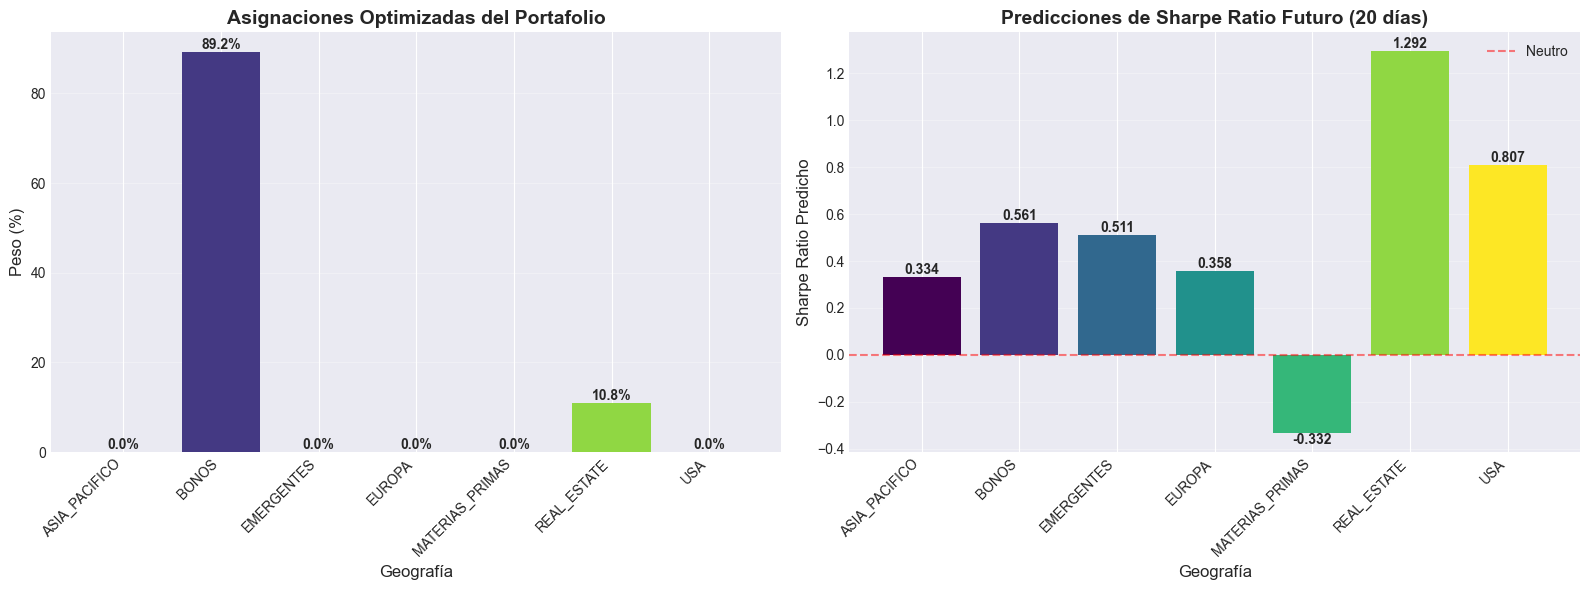


[OK] Gráfico guardado en data/visualizations/portfolio_optimization.png

Tabla de asignaciones:
Geografía            Peso (%)     Sharpe Predicho
--------------------------------------------------
ASIA_PACIFICO              0.00%         0.3340
BONOS                     89.16%         0.5608
EMERGENTES                 0.00%         0.5105
EUROPA                     0.00%         0.3578
MATERIAS_PRIMAS            0.00%        -0.3318
REAL_ESTATE               10.84%         1.2920
USA                        0.00%         0.8075
--------------------------------------------------
TOTAL                    100.00%


In [15]:
# Visualizar pesos optimizados
weights_file = os.path.join(data_dir, 'portfolio_weights_latest.pkl')

if os.path.exists(weights_file):
    with open(weights_file, 'rb') as f:
        results = pickle.load(f)
    
    weights = results['weights']
    predictions = results['predictions']
    
    print("\n✅ Pesos optimizados del portafolio:")
    
    # Crear gráfico de barras
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Gráfico 1: Pesos
    ax1 = axes[0]
    geos = list(weights.keys())
    weights_values = [weights[geo] * 100 for geo in geos]
    colors = plt.cm.viridis(np.linspace(0, 1, len(geos)))
    
    bars = ax1.bar(geos, weights_values, color=colors)
    ax1.set_title('Asignaciones Optimizadas del Portafolio', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Peso (%)', fontsize=12)
    ax1.set_xlabel('Geografía', fontsize=12)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Agregar valores en las barras
    for bar, val in zip(bars, weights_values):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Gráfico 2: Predicciones de Sharpe
    ax2 = axes[1]
    pred_geos = list(predictions.keys())
    pred_values = [predictions[geo] for geo in pred_geos]
    
    bars2 = ax2.bar(pred_geos, pred_values, color=colors[:len(pred_geos)])
    ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='Neutro')
    ax2.set_title('Predicciones de Sharpe Ratio Futuro (20 días)', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Sharpe Ratio Predicho', fontsize=12)
    ax2.set_xlabel('Geografía', fontsize=12)
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.legend()
    
    # Agregar valores
    for bar, val in zip(bars2, pred_values):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.3f}', ha='center', va='bottom' if val > 0 else 'top', fontweight='bold')
    
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    os.makedirs(os.path.join(data_dir, 'visualizations'), exist_ok=True)
    plt.savefig(os.path.join(data_dir, 'visualizations', 'portfolio_optimization.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n[OK] Gráfico guardado en {data_dir}/visualizations/portfolio_optimization.png")
    
    # Mostrar tabla de pesos
    print("\nTabla de asignaciones:")
    print(f"{'Geografía':<20} {'Peso (%)':<12} {'Sharpe Predicho':<15}")
    print("-" * 50)
    for geo in sorted(weights.keys()):
        weight_pct = weights[geo] * 100
        sharpe = predictions.get(geo, np.nan)
        print(f"{geo:<20} {weight_pct:>10.2f}% {sharpe:>14.4f}")
    print("-" * 50)
    print(f"{'TOTAL':<20} {sum(weights.values())*100:>10.2f}%")
else:
    print("❌ Error: No se encontraron pesos optimizados")

## Paso 7: Backtesting del Sistema Completo

In [16]:
# ============================================================================# PASO 7: BACKTESTING DEL SISTEMA COMPLETO# ============================================================================# Este paso simula el trading histórico usando el modelo entrenado.# El código está integrado directamente en el notebook para mayor claridad."""Script para hacer backtesting del sistema completo de predicción y optimización.Este script:1. Simula el trading histórico usando el modelo entrenado2. Re-balancea el portafolio periódicamente basado en predicciones3. Calcula métricas de performance (Sharpe, retorno, drawdown, etc.)4. Compara con benchmarks (SPY, 1/N, etc.)"""import pandas as pdimport numpy as npimport pickleimport osfrom datetime import datetime, timedeltaimport warningswarnings.filterwarnings('ignore')# Importar funciones de otros módulosfrom train_sharpe_predictor import load_ml_dataset, prepare_data, split_data_temporalfrom optimize_portfolio import load_models, predict_sharpe_ratios, optimize_portfolioimport osdef load_returns_data(data_dir='data'):    """Carga retornos históricos de ETFs"""    returns_file = os.path.join(data_dir, 'etf_returns_dict.pkl')        if not os.path.exists(returns_file):        raise FileNotFoundError(f"No se encontró {returns_file}")        with open(returns_file, 'rb') as f:        returns_dict = pickle.load(f)        return returns_dictdef calculate_portfolio_returns(weights_dict, returns_dict, geographies):    """    Calcula retornos del portafolio basado en pesos y retornos históricos.        Parameters:    -----------    weights_dict : dict        Pesos por geografía (puede variar en el tiempo)    returns_dict : dict        Retornos históricos por ETF    geographies : list        Lista de geografías        Returns:    --------    pd.Series: Retornos del portafolio    """    # Definir ETFs por geografía    ETFS_BY_GEOGRAPHY = {        'USA': ['SPY', 'QQQ', 'IWM'],        'EUROPA': ['VGK'],        'ASIA_PACIFICO': ['VPL'],        'EMERGENTES': ['EEM'],        'BONOS': ['TLT', 'LQD', 'HYG', 'SHY'],        'MATERIAS_PRIMAS': ['GLD', 'USO', 'DJP'],        'REAL_ESTATE': ['VNQ']    }        # Calcular retornos por geografía    geo_returns = {}        for geo in geographies:        if geo not in ETFS_BY_GEOGRAPHY:            continue                etfs = ETFS_BY_GEOGRAPHY[geo]        available_etfs = [etf for etf in etfs if etf in returns_dict]                if len(available_etfs) == 0:            continue                # Retorno promedio de la geografía        geo_returns_list = []        for etf in available_etfs:            if etf in returns_dict:                geo_returns_list.append(returns_dict[etf])                if len(geo_returns_list) > 0:            geo_returns_df = pd.DataFrame(geo_returns_list).T            geo_returns[geo] = geo_returns_df.mean(axis=1, skipna=True)        # Crear DataFrame con retornos por geografía    returns_df = pd.DataFrame(geo_returns)    returns_df = returns_df.dropna()        # Normalizar índices de fecha (eliminar timezone si existe)    if isinstance(returns_df.index, pd.DatetimeIndex):        if returns_df.index.tz is not None:            returns_df.index = returns_df.index.tz_localize(None)        returns_df.index = returns_df.index.normalize()        # Calcular retornos del portafolio    if isinstance(weights_dict, dict):        # Pesos constantes        weights = np.array([weights_dict.get(geo, 0) for geo in returns_df.columns])        portfolio_returns = (returns_df * weights).sum(axis=1)    else:        # Pesos variables en el tiempo (DataFrame)        # Normalizar índice de weights también        if isinstance(weights_dict.index, pd.DatetimeIndex):            if weights_dict.index.tz is not None:                weights_dict.index = weights_dict.index.tz_localize(None)            weights_dict.index = weights_dict.index.normalize()        # Alinear fechas        aligned_weights = weights_dict.reindex(returns_df.index, method='ffill')        portfolio_returns = (returns_df * aligned_weights).sum(axis=1)        return portfolio_returnsdef calculate_metrics(returns, risk_free_rate=0.02):    """    Calcula métricas de performance del portafolio.        Parameters:    -----------    returns : pd.Series        Retornos del portafolio    risk_free_rate : float        Tasa libre de riesgo anualizada        Returns:    --------    dict: Métricas de performance    """    returns = returns.dropna()        if len(returns) == 0:        return {            'total_return': 0,            'annualized_return': 0,            'volatility': 0,            'sharpe_ratio': 0,            'max_drawdown': 0,            'win_rate': 0        }        # Detectar y manejar valores extremos (outliers)    # Retornos diarios típicamente están entre -10% y +10%    # Valores fuera de este rango pueden ser errores    q1 = returns.quantile(0.01)    q99 = returns.quantile(0.99)        # Filtrar outliers extremos (más de 3 desviaciones estándar)    mean_ret = returns.mean()    std_ret = returns.std()    outlier_threshold = 3 * std_ret        # Identificar outliers pero no eliminarlos todavía (solo para reporte)    outliers = returns[(returns.abs() > abs(mean_ret) + outlier_threshold)]        # Los retornos del portafolio vienen de calculate_portfolio_returns    # que calcula: (returns_df * weights).sum(axis=1)    # donde returns_df contiene retornos en porcentaje (ej: 0.5 = 0.5%)    # Por lo tanto, los retornos del portafolio también están en porcentaje        # Verificar formato basado en el rango típico    sample_values = returns.dropna()    if len(sample_values) > 0:        max_abs = sample_values.abs().max()        mean_abs = sample_values.abs().mean()                # Retornos diarios típicos: -5% a +5% (valores entre -5 y 5)        # Si están en decimal: -0.05 a +0.05 (valores entre -0.05 y 0.05)        if mean_abs < 0.1 and max_abs < 1:  # Probablemente en decimal            returns_pct = returns * 100  # Convertir a porcentaje        elif mean_abs > 50 or max_abs > 100:  # Valores extremos, error            print(f"    [WARNING] Valores extremos detectados (max_abs={max_abs:.2f})")            # Capar valores extremos            returns_pct = returns.clip(lower=-50, upper=50)  # Limitar a ±50%        else:  # Ya están en porcentaje (rango típico)            returns_pct = returns    else:        returns_pct = returns        # Verificar si hay valores extremos después de normalizar    if len(outliers) > 0 and len(outliers) < len(returns) * 0.05:  # Menos del 5% son outliers        # Reemplazar outliers con valores límite (winsorization)        returns_pct_clean = returns_pct.copy()        lower_bound = returns_pct.quantile(0.01)        upper_bound = returns_pct.quantile(0.99)        returns_pct_clean = returns_pct_clean.clip(lower=lower_bound, upper=upper_bound)        returns_pct = returns_pct_clean        # Retorno total (asumiendo retornos en porcentaje)    total_return = (1 + returns_pct / 100).prod() - 1        # Retorno anualizado    years = len(returns) / 252    annualized_return = (1 + total_return) ** (1 / years) - 1 if years > 0 else 0        # Volatilidad anualizada    # Los retornos están en porcentaje diario (ej: 0.5 = 0.5%)    # std() da desviación estándar diaria en porcentaje    # Multiplicar por sqrt(252) para anualizar    volatility_daily = returns_pct.std()    volatility = volatility_daily * np.sqrt(252)  # Anualizada, en porcentaje        # Sharpe Ratio    # annualized_return está en decimal (ej: 0.1 = 10%)    # volatility está en porcentaje (ej: 15 = 15%)    # Convertir volatility a decimal para el cálculo    excess_return = annualized_return - risk_free_rate    volatility_decimal = volatility / 100  # Convertir a decimal para Sharpe    sharpe_ratio = excess_return / volatility_decimal if volatility_decimal > 0 else 0        # Drawdown máximo (usar returns_pct que ya está normalizado)    cumulative = (1 + returns_pct / 100).cumprod()    running_max = cumulative.expanding().max()    drawdown = (cumulative - running_max) / running_max    max_drawdown = drawdown.min()        # Win rate    win_rate = (returns > 0).sum() / len(returns)        return {        'total_return': total_return,        'annualized_return': annualized_return,        'volatility': volatility,  # En porcentaje anualizado        'sharpe_ratio': sharpe_ratio,        'max_drawdown': max_drawdown,        'win_rate': win_rate,        'num_trades': len(returns)    }def backtest_walk_forward(dataset, models, returns_dict,                           rebalance_frequency='quarterly',  # ESTRATEGIA 7: Más conservador                          train_years=5,                          start_date=None,                          end_date=None,                          min_weight_change=0.1,  # ESTRATEGIA 7: Solo re-balancear si cambio > 10%                          stop_loss_threshold=-0.15):  # ESTRATEGIA 4.4: Stop-loss a -15%    """    Backtesting walk-forward: entrena y prueba en ventanas deslizantes.        Parameters:    -----------    dataset : pd.DataFrame        Dataset completo con features y targets    models : dict        Modelos entrenados (se re-entrenan en cada ventana)    returns_dict : dict        Retornos históricos    rebalance_frequency : str        'daily', 'weekly', 'monthly'    train_years : int        Años de datos para entrenar en cada ventana    start_date : datetime, optional        Fecha de inicio del backtest    end_date : datetime, optional        Fecha de fin del backtest    """    print("=" * 80)    print("BACKTESTING WALK-FORWARD")    print("=" * 80)        # Preparar datos    feature_cols = [col for col in dataset.columns if not col.startswith('target_')]    target_cols = [col for col in dataset.columns if col.startswith('target_')]        # Normalizar índices de fecha (eliminar timezone si existe)    if isinstance(dataset.index, pd.DatetimeIndex):        if dataset.index.tz is not None:            dataset.index = dataset.index.tz_localize(None)        dataset.index = dataset.index.normalize()        # Filtrar por fechas    if start_date:        if isinstance(start_date, pd.Timestamp) and start_date.tz is not None:            start_date = start_date.tz_localize(None)        dataset = dataset[dataset.index >= start_date]    if end_date:        if isinstance(end_date, pd.Timestamp) and end_date.tz is not None:            end_date = end_date.tz_localize(None)        dataset = dataset[dataset.index <= end_date]        dataset = dataset.sort_index()        # ESTRATEGIA 7: Determinar fechas de re-balanceo (más conservador)    if rebalance_frequency == 'daily':        rebalance_dates = dataset.index.tolist()    elif rebalance_frequency == 'weekly':        rebalance_dates = dataset.index[::5].tolist()  # Cada 5 días hábiles    elif rebalance_frequency == 'monthly':        # Obtener fechas mensuales        monthly_periods = dataset.index.to_period('M').drop_duplicates()        rebalance_dates = []        for period in monthly_periods:            month_start = period.to_timestamp()            month_dates = dataset[dataset.index >= month_start].index            if len(month_dates) > 0:                rebalance_dates.append(month_dates[0])        rebalance_dates = sorted(list(set(rebalance_dates)))    elif rebalance_frequency == 'quarterly':  # ESTRATEGIA 7: Trimestral        quarterly_periods = dataset.index.to_period('Q').drop_duplicates()        rebalance_dates = []        for period in quarterly_periods:            quarter_start = period.to_timestamp()            quarter_dates = dataset[dataset.index >= quarter_start].index            if len(quarter_dates) > 0:                rebalance_dates.append(quarter_dates[0])        rebalance_dates = sorted(list(set(rebalance_dates)))    else:        raise ValueError(f"Frecuencia desconocida: {rebalance_frequency}")        print(f"\nFechas de re-balanceo: {len(rebalance_dates)}")    print(f"  Primera: {rebalance_dates[0]}")    print(f"  Última: {rebalance_dates[-1]}")        # Almacenar pesos y retornos en el tiempo    portfolio_weights = {}    portfolio_returns_list = []    previous_weights = None  # ESTRATEGIA 4.2: Para turnover constraint    cumulative_value = 1.0  # ESTRATEGIA 4.4: Para stop-loss        # Backtesting    print("\nEjecutando backtesting...")    print(f"  [ESTRATEGIA 7] Re-balanceo: {rebalance_frequency}")    print(f"  [ESTRATEGIA 7] Cambio mínimo para re-balancear: {min_weight_change*100:.0f}%")    print(f"  [ESTRATEGIA 4.4] Stop-loss: {stop_loss_threshold*100:.0f}%")        successful_predictions = 0    failed_predictions = 0    skipped_rebalances = 0  # ESTRATEGIA 7: Contador de re-balanceos saltados        for i, rebalance_date in enumerate(rebalance_dates):        if i % 50 == 0:            print(f"  Procesando fecha {i+1}/{len(rebalance_dates)}: {rebalance_date}")                # Normalizar fecha de rebalanceo        if isinstance(rebalance_date, pd.Timestamp):            if rebalance_date.tz is not None:                rebalance_date = rebalance_date.tz_localize(None)            rebalance_date = rebalance_date.normalize()                # Obtener datos hasta esta fecha (sin data leakage)        data_until_date = dataset[dataset.index <= rebalance_date]                if len(data_until_date) < train_years * 252:            # No hay suficientes datos para entrenar            continue                # Obtener features actuales        X_current = data_until_date.iloc[[-1]]                # Generar predicciones        try:            # ESTRATEGIA 9: Obtener VIX si está disponible para gestión de riesgo dinámica            vix_level = None            if 'VIX_value' in X_current.columns:                vix_val = X_current['VIX_value'].iloc[-1]                if not np.isnan(vix_val):                    vix_level = vix_val                        # Cargar métricas de modelos si están disponibles (ESTRATEGIA 8)            model_metrics = None            try:                import json                models_dir = 'models'                metrics_files = [f for f in os.listdir(models_dir) if f.startswith('metrics_') and f.endswith('.json')]                if len(metrics_files) > 0:                    model_metrics = {}                    for metrics_file in metrics_files:                        geo = metrics_file.replace('metrics_', '').replace('.json', '')                        metrics_path = os.path.join(models_dir, metrics_file)                        with open(metrics_path, 'r') as f:                            metrics_data = json.load(f)                            model_metrics[geo] = {'r2': metrics_data.get('best_r2_val', 0)}            except Exception as e:                pass                        sharpe_predictions = predict_sharpe_ratios(models, X_current, model_metrics=model_metrics)                        # Verificar que hay predicciones válidas            valid_predictions = {k: v for k, v in sharpe_predictions.items() if not np.isnan(v)}            if len(valid_predictions) == 0:                failed_predictions += 1                continue                        # ESTRATEGIA 4.4: Aplicar stop-loss si el portafolio ha caído demasiado            if cumulative_value < (1 + stop_loss_threshold):                print(f"    [ESTRATEGIA 4.4] Stop-loss activado (valor: {cumulative_value:.4f}), reduciendo exposición")                # Reducir todos los pesos a la mitad y aumentar cash (bonos)                if previous_weights:                    weights = {k: v * 0.5 for k, v in previous_weights.items()}                    # El resto va a bonos (SHY)                    total_reduced = sum(weights.values())                    if 'BONOS' in weights:                        weights['BONOS'] += (1.0 - total_reduced)                    else:                        weights['BONOS'] = (1.0 - total_reduced)                else:                    # Si no hay pesos anteriores, usar pesos conservadores                    weights = {'BONOS': 0.7, 'USA': 0.2, 'EUROPA': 0.1}            else:                # Optimizar portafolio con mejoras                weights = optimize_portfolio(                    sharpe_predictions,                    min_weight=0.0,                    max_weight=0.3,  # ESTRATEGIA 4: Más conservador (30% en lugar de 40%)                    returns_dict=returns_dict,                    previous_weights=previous_weights,  # ESTRATEGIA 4.2: Turnover constraint                    max_volatility=0.25,  # ESTRATEGIA 4.1: Límite de volatilidad                    max_turnover=0.2,  # ESTRATEGIA 4.2: Máximo 20% de cambio                    vix_level=vix_level  # ESTRATEGIA 9: Gestión de riesgo dinámica                )                        if weights is None or len(weights) == 0:                failed_predictions += 1                continue                        # ESTRATEGIA 7: Solo re-balancear si el cambio es significativo            if previous_weights is not None:                # Calcular cambio total                total_change = sum(abs(weights.get(geo, 0) - previous_weights.get(geo, 0))                                  for geo in set(list(weights.keys()) + list(previous_weights.keys())))                                if total_change < min_weight_change:                    # Cambio muy pequeño, mantener pesos anteriores                    skipped_rebalances += 1                    weights = previous_weights.copy()                else:                    # Cambio significativo, usar nuevos pesos                    portfolio_weights[rebalance_date] = weights                    previous_weights = weights.copy()                    successful_predictions += 1            else:                # Primera vez, usar los pesos optimizados                portfolio_weights[rebalance_date] = weights                previous_weights = weights.copy()                successful_predictions += 1                        # Calcular retorno del portafolio para este período            # (hasta el próximo re-balanceo o fin de datos)            if i < len(rebalance_dates) - 1:                next_date = rebalance_dates[i + 1]                # Normalizar next_date también                if isinstance(next_date, pd.Timestamp):                    if next_date.tz is not None:                        next_date = next_date.tz_localize(None)                    next_date = next_date.normalize()                                # Filtrar retornos del período                period_returns = calculate_portfolio_returns(                    weights, returns_dict, list(weights.keys())                )                                # Normalizar índice de period_returns si es necesario                if isinstance(period_returns.index, pd.DatetimeIndex):                    if period_returns.index.tz is not None:                        period_returns.index = period_returns.index.tz_localize(None)                    period_returns.index = period_returns.index.normalize()                                # Filtrar por rango de fechas                period_mask = (period_returns.index > rebalance_date) & (period_returns.index <= next_date)                period_returns_filtered = period_returns[period_mask]            else:                # Último período: desde rebalance_date hasta el fin                period_returns = calculate_portfolio_returns(                    weights, returns_dict, list(weights.keys())                )                                # Normalizar índice                if isinstance(period_returns.index, pd.DatetimeIndex):                    if period_returns.index.tz is not None:                        period_returns.index = period_returns.index.tz_localize(None)                    period_returns.index = period_returns.index.normalize()                                period_mask = period_returns.index > rebalance_date                period_returns_filtered = period_returns[period_mask]                        if len(period_returns_filtered) > 0:                portfolio_returns_list.append(period_returns_filtered)                                # ESTRATEGIA 4.4: Actualizar valor acumulado para stop-loss                period_cumulative = (1 + period_returns_filtered / 100).prod()                cumulative_value *= period_cumulative                except Exception as e:            failed_predictions += 1            if i % 50 == 0 or i < 5:  # Mostrar primeros errores y luego cada 50                print(f"    [WARNING] Error en {rebalance_date}: {e}")                import traceback                if i < 5:  # Mostrar traceback completo para primeros errores                    traceback.print_exc()            continue        print(f"\n  Predicciones exitosas: {successful_predictions}")    print(f"  Predicciones fallidas: {failed_predictions}")    print(f"  Re-balanceos saltados (cambio < {min_weight_change*100:.0f}%): {skipped_rebalances}")        # Combinar todos los retornos    if len(portfolio_returns_list) > 0:        try:            portfolio_returns = pd.concat(portfolio_returns_list).sort_index()            portfolio_returns = portfolio_returns[~portfolio_returns.index.duplicated(keep='first')]            print(f"\n  Retornos generados: {len(portfolio_returns)} observaciones")            print(f"  Rango de fechas: {portfolio_returns.index.min()} a {portfolio_returns.index.max()}")        except Exception as e:            print(f"\n[ERROR] Error combinando retornos: {e}")            print(f"  Número de listas: {len(portfolio_returns_list)}")            if len(portfolio_returns_list) > 0:                print(f"  Primer elemento: {type(portfolio_returns_list[0])}, longitud: {len(portfolio_returns_list[0])}")            portfolio_returns = pd.Series(dtype=float)    else:        print(f"\n[WARNING] No se generaron retornos del portafolio")        print(f"  Predicciones exitosas: {successful_predictions}")        print(f"  Predicciones fallidas: {failed_predictions}")        portfolio_returns = pd.Series(dtype=float)        return portfolio_returns, portfolio_weightsdef compare_with_benchmarks(portfolio_returns, returns_dict, risk_free_rate=0.02):    """Compara performance con benchmarks"""    benchmarks = {}        # 1. SPY (mercado)    if 'SPY' in returns_dict:        benchmarks['SPY'] = returns_dict['SPY']        # 2. Portafolio 1/N (igualmente ponderado)    geographies = ['USA', 'EUROPA', 'ASIA_PACIFICO', 'EMERGENTES', 'BONOS', 'MATERIAS_PRIMAS', 'REAL_ESTATE']    ETFS_BY_GEOGRAPHY = {        'USA': ['SPY', 'QQQ', 'IWM'],        'EUROPA': ['VGK'],        'ASIA_PACIFICO': ['VPL'],        'EMERGENTES': ['EEM'],        'BONOS': ['TLT', 'LQD', 'HYG', 'SHY'],        'MATERIAS_PRIMAS': ['GLD', 'USO', 'DJP'],        'REAL_ESTATE': ['VNQ']    }        # Calcular retornos 1/N    geo_returns_list = []    for geo in geographies:        if geo not in ETFS_BY_GEOGRAPHY:            continue        etfs = [etf for etf in ETFS_BY_GEOGRAPHY[geo] if etf in returns_dict]        if len(etfs) > 0:            geo_ret = pd.DataFrame({etf: returns_dict[etf] for etf in etfs}).mean(axis=1)            geo_returns_list.append(geo_ret)        if len(geo_returns_list) > 0:        geo_returns_df = pd.DataFrame(geo_returns_list).T        equal_weights = np.ones(len(geo_returns_df.columns)) / len(geo_returns_df.columns)        benchmarks['1/N Portfolio'] = (geo_returns_df * equal_weights).sum(axis=1)        # Normalizar índices de fecha antes de alinear    # Portfolio returns    if isinstance(portfolio_returns.index, pd.DatetimeIndex):        if portfolio_returns.index.tz is not None:            portfolio_returns.index = portfolio_returns.index.tz_localize(None)        portfolio_returns.index = portfolio_returns.index.normalize()        # Benchmarks    benchmarks_normalized = {}    for bench_name, bench_returns in benchmarks.items():        if isinstance(bench_returns.index, pd.DatetimeIndex):            bench_returns_copy = bench_returns.copy()            if bench_returns_copy.index.tz is not None:                bench_returns_copy.index = bench_returns_copy.index.tz_localize(None)            bench_returns_copy.index = bench_returns_copy.index.normalize()            benchmarks_normalized[bench_name] = bench_returns_copy        else:            benchmarks_normalized[bench_name] = bench_returns        # Alinear fechas (ahora todas sin timezone)    all_dates = set(portfolio_returns.index)    for bench_name, bench_returns in benchmarks_normalized.items():        all_dates.update(bench_returns.index)        # Convertir a lista y ordenar (ahora todas son tz-naive)    common_dates = sorted([pd.Timestamp(d).normalize() if isinstance(d, pd.Timestamp) else d for d in all_dates])        # Filtrar a fechas comunes    portfolio_aligned = portfolio_returns.reindex(common_dates).dropna()    benchmarks_aligned = {}    for bench_name, bench_returns in benchmarks_normalized.items():        bench_aligned = bench_returns.reindex(common_dates).dropna()        if len(bench_aligned) > 0:            benchmarks_aligned[bench_name] = bench_aligned        # Calcular métricas    results = {}        # Portfolio    portfolio_metrics = calculate_metrics(portfolio_aligned, risk_free_rate)    results['Portfolio Optimizado'] = portfolio_metrics        # Benchmarks    for bench_name, bench_returns in benchmarks_aligned.items():        # Intersectar fechas        common = portfolio_aligned.index.intersection(bench_returns.index)        if len(common) > 0:            bench_metrics = calculate_metrics(bench_returns.loc[common], risk_free_rate)            results[bench_name] = bench_metrics        return resultsdef main():    """Función principal"""    print("=" * 80)    print("BACKTESTING DEL SISTEMA DE PREDICCIÓN Y OPTIMIZACIÓN")    print("=" * 80)        data_dir = 'data'    models_dir = 'models'        # 1. Cargar modelos (ESTRATEGIA 6: Intentar cargar ensembles)    print("\n1. Cargando modelos...")    models = load_models(models_dir, use_ensemble=True)    if models is None:        print("[ERROR] No se pudieron cargar modelos")        return        # Verificar tipo de modelos cargados    if models.get('type') == 'ensemble':        print(f"  [ESTRATEGIA 6] Usando ensembles: {len(models['ensembles'])} geografías")    else:        print(f"  Usando modelos individuales: {len(models.get('models', {}))} geografías")        # 2. Cargar dataset    print("\n2. Cargando dataset...")    dataset = load_ml_dataset(data_dir)        # 3. Cargar retornos    print("\n3. Cargando retornos históricos...")    returns_dict = load_returns_data(data_dir)        # 4. Ejecutar backtesting    print("\n4. Ejecutando backtesting...")    portfolio_returns, portfolio_weights = backtest_walk_forward(        dataset, models, returns_dict,        rebalance_frequency='quarterly',  # ESTRATEGIA 7: Re-balancear trimestralmente        train_years=5,        min_weight_change=0.1,  # ESTRATEGIA 7: Solo re-balancear si cambio > 10%        stop_loss_threshold=-0.15  # ESTRATEGIA 4.4: Stop-loss a -15%    )        if len(portfolio_returns) == 0:        print("[ERROR] No se generaron retornos del portafolio")        return        # 5. Diagnóstico de retornos    print("\n5. Diagnóstico de retornos del portafolio...")    if len(portfolio_returns) > 0:        print(f"  Observaciones: {len(portfolio_returns):,}")        print(f"  Rango de valores: [{portfolio_returns.min():.4f}, {portfolio_returns.max():.4f}]")        print(f"  Media: {portfolio_returns.mean():.4f}")        print(f"  Mediana: {portfolio_returns.median():.4f}")        print(f"  Desviación estándar (diaria): {portfolio_returns.std():.4f}")        print(f"  Percentiles: P1={portfolio_returns.quantile(0.01):.4f}, P99={portfolio_returns.quantile(0.99):.4f}")                # Detectar posibles problemas        if portfolio_returns.std() > 50:            print(f"  [WARNING] Desviación estándar muy alta ({portfolio_returns.std():.2f})")            print(f"            Esto puede indicar valores extremos o error en el cálculo")                # Mostrar algunos valores de ejemplo        print(f"  Primeros 5 valores:")        for i, (date, val) in enumerate(portfolio_returns.head().items()):            print(f"    {date}: {val:.4f}")        # 6. Calcular métricas    print("\n6. Calculando métricas de performance...")    portfolio_metrics = calculate_metrics(portfolio_returns)        print("\n" + "=" * 80)    print("MÉTRICAS DEL PORTAFOLIO OPTIMIZADO")    print("=" * 80)    print(f"\nPeríodo: {portfolio_returns.index.min()} a {portfolio_returns.index.max()}")    print(f"Retorno Total:        {portfolio_metrics['total_return']*100:>8.2f}%")    print(f"Retorno Anualizado:   {portfolio_metrics['annualized_return']*100:>8.2f}%")    print(f"Volatilidad:           {portfolio_metrics['volatility']*100:>8.2f}%")    print(f"Sharpe Ratio:         {portfolio_metrics['sharpe_ratio']:>8.4f}")    print(f"Drawdown Máximo:      {portfolio_metrics['max_drawdown']*100:>8.2f}%")    print(f"Win Rate:             {portfolio_metrics['win_rate']*100:>8.2f}%")        # 7. Comparar con benchmarks    print("\n7. Comparando con benchmarks...")    comparison = compare_with_benchmarks(portfolio_returns, returns_dict)        print("\n" + "=" * 80)    print("COMPARACIÓN CON BENCHMARKS")    print("=" * 80)    print(f"\n{'Estrategia':<25} {'Retorno An.':<12} {'Sharpe':<10} {'Drawdown':<10}")    print("-" * 60)        for strategy, metrics in comparison.items():        ret = metrics['annualized_return'] * 100        sharpe = metrics['sharpe_ratio']        dd = metrics['max_drawdown'] * 100        print(f"{strategy:<25} {ret:>10.2f}% {sharpe:>9.4f} {dd:>9.2f}%")        # 7. Guardar resultados    results = {        'portfolio_returns': portfolio_returns,        'portfolio_weights': portfolio_weights,        'metrics': portfolio_metrics,        'comparison': comparison    }        results_file = os.path.join(data_dir, 'backtest_results.pkl')    with open(results_file, 'wb') as f:        pickle.dump(results, f)        print(f"\n[OK] Resultados guardados en {results_file}")        # 8. Visualizar resultados    print("\n8. Generando visualizaciones...")    try:        import sys        current_dir = os.path.dirname(os.path.abspath(__file__))        sys.path.insert(0, current_dir)        from visualize_backtest_results import visualize_backtest_results        visualize_backtest_results(portfolio_returns, results, data_dir)    except ImportError as e:        print(f"    [WARNING] No se pudo importar visualize_backtest_results: {e}")        print("    Instala matplotlib: pip install matplotlib")    except Exception as e:        print(f"    [WARNING] Error en visualización: {e}")        import traceback        traceback.print_exc()        print("\n" + "=" * 80)    print("BACKTESTING COMPLETADO")    print("=" * 80)if __name__ == "__main__":    main()# Ejecutar la función main (si existe)print("=" * 80)print("PASO 7: BACKTESTING DEL SISTEMA COMPLETO")print("=" * 80)if 'main' in globals():    main()else:    print("Las funciones de backtesting están disponibles para uso directo.")

PASO 7: BACKTESTING DEL SISTEMA COMPLETO

[NOTA] Este paso puede tardar varios minutos...
BACKTESTING DEL SISTEMA DE PREDICCIÓN Y OPTIMIZACIÓN

1. Cargando modelos...

Cargando modelos desde models...
  [ESTRATEGIA 6] Cargando ensembles (7 encontrados)...
    [OK] ASIA_PACIFICO: ensemble con 3 modelos
    [OK] BONOS: ensemble con 3 modelos
    [OK] EMERGENTES: ensemble con 3 modelos
    [OK] EUROPA: ensemble con 3 modelos
    [OK] MATERIAS_PRIMAS: ensemble con 3 modelos
    [OK] REAL_ESTATE: ensemble con 3 modelos
    [OK] USA: ensemble con 3 modelos
  [ESTRATEGIA 6] Usando ensembles: 7 geografías

2. Cargando dataset...
[OK] Cargando dataset desde data\ml_dataset.pkl...

3. Cargando retornos históricos...

4. Ejecutando backtesting...
BACKTESTING WALK-FORWARD

Fechas de re-balanceo: 80
  Primera: 2006-02-02 00:00:00
  Última: 2025-10-01 00:00:00

Ejecutando backtesting...
  [ESTRATEGIA 7] Re-balanceo: quarterly
  [ESTRATEGIA 7] Cambio mínimo para re-balancear: 10%
  [ESTRATEGIA 4.4] S

In [17]:
# Cargar y visualizar resultados del backtesting
backtest_results_file = os.path.join(data_dir, 'backtest_results.pkl')

if os.path.exists(backtest_results_file):
    with open(backtest_results_file, 'rb') as f:
        backtest_results = pickle.load(f)
    
    portfolio_returns = backtest_results['portfolio_returns']
    portfolio_metrics = backtest_results['metrics']
    comparison = backtest_results.get('comparison', {})
    
    print("\n✅ Resultados del backtesting cargados")
    
    # Mostrar métricas
    print("\n" + "=" * 80)
    print("MÉTRICAS DEL PORTAFOLIO OPTIMIZADO")
    print("=" * 80)
    print(f"\nPeríodo: {portfolio_returns.index.min()} a {portfolio_returns.index.max()}")
    print(f"Retorno Total:           {portfolio_metrics['total_return']*100:>8.2f}%")
    print(f"Retorno Anualizado:      {portfolio_metrics['annualized_return']*100:>8.2f}%")
    print(f"Volatilidad:             {portfolio_metrics['volatility']:>8.2f}%")
    print(f"Sharpe Ratio:            {portfolio_metrics['sharpe_ratio']:>8.4f}")
    print(f"Drawdown Máximo:         {portfolio_metrics['max_drawdown']*100:>8.2f}%")
    print(f"Win Rate:                {portfolio_metrics['win_rate']*100:>8.2f}%")
    
    # Comparación con benchmarks
    if len(comparison) > 0:
        print("\n" + "=" * 80)
        print("COMPARACIÓN CON BENCHMARKS")
        print("=" * 80)
        print(f"\n{'Estrategia':<25} {'Retorno An.':<12} {'Sharpe':<10} {'Drawdown':<10}")
        print("-" * 60)
        
        for strategy, metrics in comparison.items():
            ret = metrics['annualized_return'] * 100
            sharpe = metrics['sharpe_ratio']
            dd = metrics['max_drawdown'] * 100
            print(f"{strategy:<25} {ret:>10.2f}% {sharpe:>9.4f} {dd:>9.2f}%")
    
else:
    print("❌ Error: No se encontraron resultados de backtesting")


✅ Resultados del backtesting cargados

MÉTRICAS DEL PORTAFOLIO OPTIMIZADO

Período: 2011-04-04 00:00:00 a 2026-01-26 00:00:00
Retorno Total:             116.88%
Retorno Anualizado:          5.56%
Volatilidad:                 6.50%
Sharpe Ratio:              0.5485
Drawdown Máximo:           -19.74%
Win Rate:                   55.01%

COMPARACIÓN CON BENCHMARKS

Estrategia                Retorno An.  Sharpe     Drawdown  
------------------------------------------------------------
Portfolio Optimizado            5.56%    0.5485    -19.74%
SPY                            14.29%    0.8136    -23.65%
1/N Portfolio                   7.49%    0.4525    -22.20%


## Paso 8: Visualizaciones Detalladas

PASO 8: GENERANDO VISUALIZACIONES


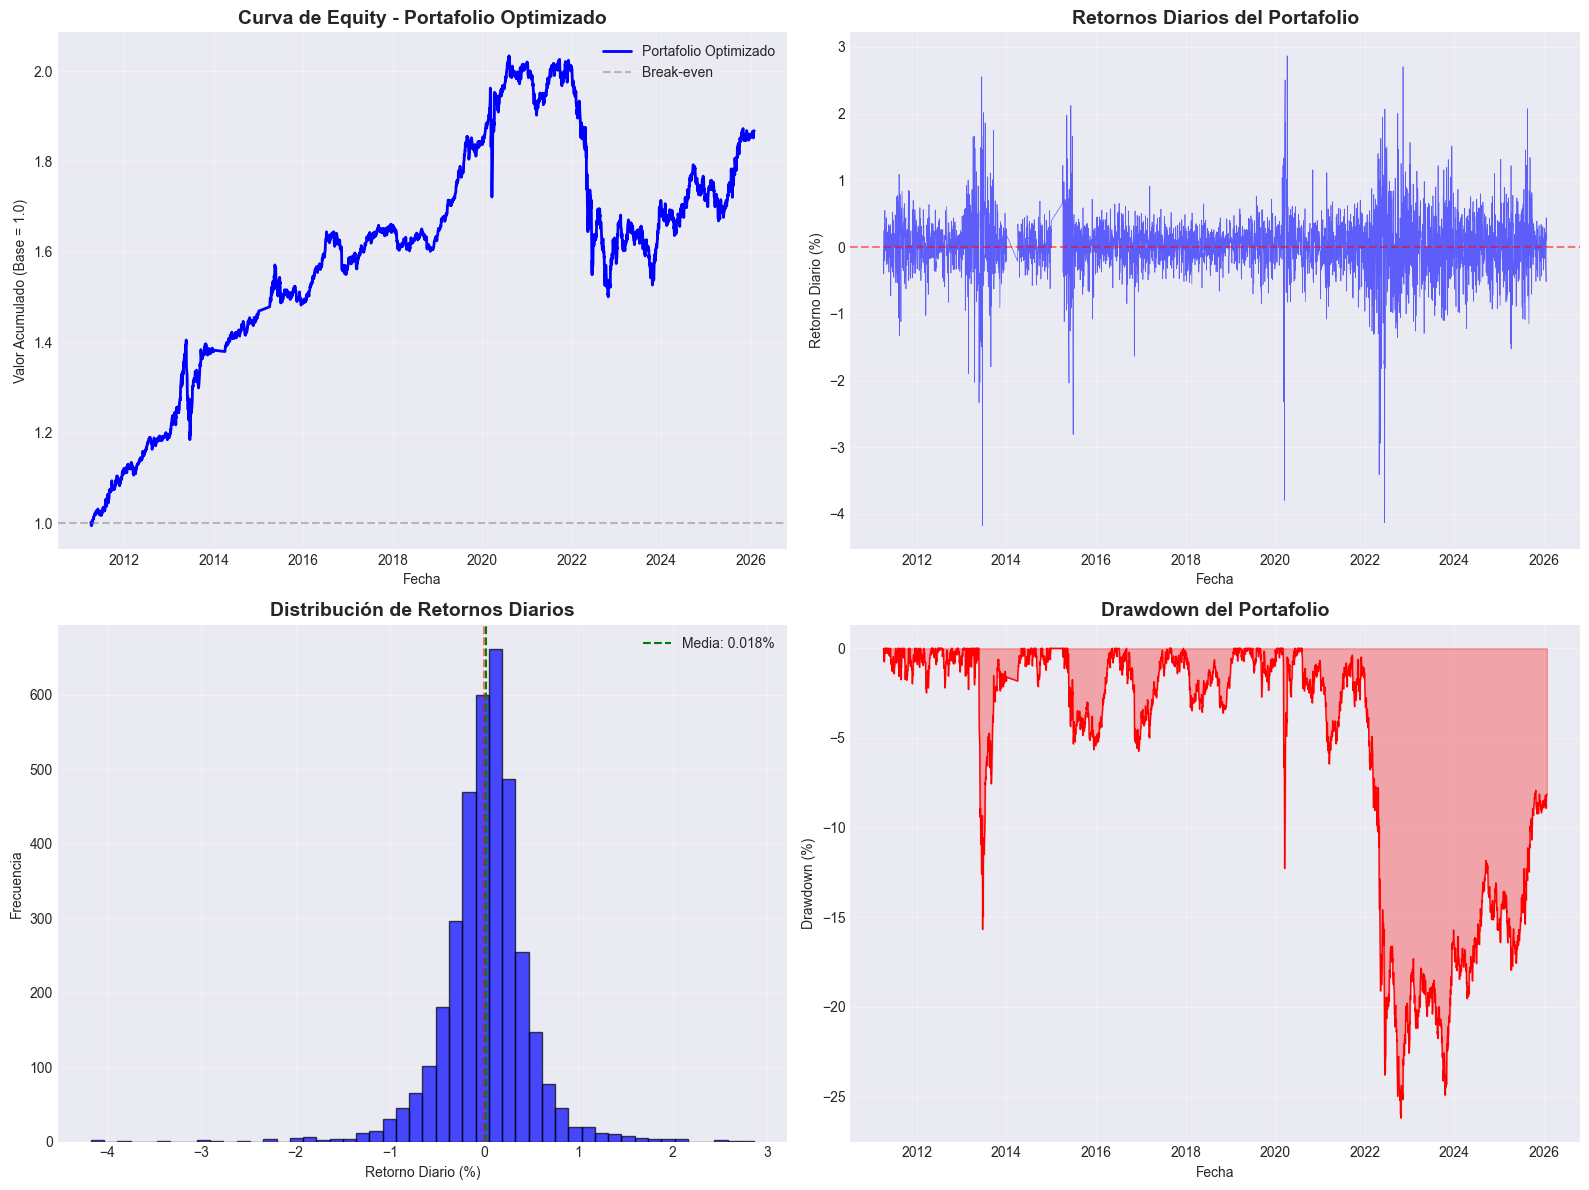


[OK] Gráfico guardado en data/visualizations/backtest_analysis_complete.png


In [18]:
# Generar visualizaciones completas
print("=" * 80)
print("PASO 8: GENERANDO VISUALIZACIONES")
print("=" * 80)

# Cargar resultados si no están cargados
if 'backtest_results' not in locals():
    with open(backtest_results_file, 'rb') as f:
        backtest_results = pickle.load(f)
    portfolio_returns = backtest_results['portfolio_returns']

# Crear visualizaciones
os.makedirs(os.path.join(data_dir, 'visualizations'), exist_ok=True)

# 1. Análisis completo del portafolio
cumulative = (1 + portfolio_returns / 100).cumprod()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Curva de equity
ax1 = axes[0, 0]
ax1.plot(cumulative.index, cumulative.values, linewidth=2, label='Portafolio Optimizado', color='blue')
ax1.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5, label='Break-even')
ax1.set_title('Curva de Equity - Portafolio Optimizado', fontsize=14, fontweight='bold')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Valor Acumulado (Base = 1.0)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Retornos diarios
ax2 = axes[0, 1]
ax2.plot(portfolio_returns.index, portfolio_returns.values, alpha=0.6, linewidth=0.5, color='blue')
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5)
ax2.set_title('Retornos Diarios del Portafolio', fontsize=14, fontweight='bold')
ax2.set_xlabel('Fecha')
ax2.set_ylabel('Retorno Diario (%)')
ax2.grid(True, alpha=0.3)

# Distribución de retornos
ax3 = axes[1, 0]
ax3.hist(portfolio_returns.values, bins=50, alpha=0.7, edgecolor='black', color='blue')
ax3.axvline(x=0, color='red', linestyle='--', alpha=0.5)
ax3.axvline(x=portfolio_returns.mean(), color='green', linestyle='--', 
            label=f'Media: {portfolio_returns.mean():.3f}%')
ax3.set_title('Distribución de Retornos Diarios', fontsize=14, fontweight='bold')
ax3.set_xlabel('Retorno Diario (%)')
ax3.set_ylabel('Frecuencia')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Drawdown
ax4 = axes[1, 1]
running_max = cumulative.expanding().max()
drawdown = (cumulative - running_max) / running_max * 100
ax4.fill_between(drawdown.index, drawdown.values, 0, alpha=0.3, color='red')
ax4.plot(drawdown.index, drawdown.values, color='red', linewidth=1)
ax4.set_title('Drawdown del Portafolio', fontsize=14, fontweight='bold')
ax4.set_xlabel('Fecha')
ax4.set_ylabel('Drawdown (%)')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(data_dir, 'visualizations', 'backtest_analysis_complete.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\n[OK] Gráfico guardado en {data_dir}/visualizations/backtest_analysis_complete.png")

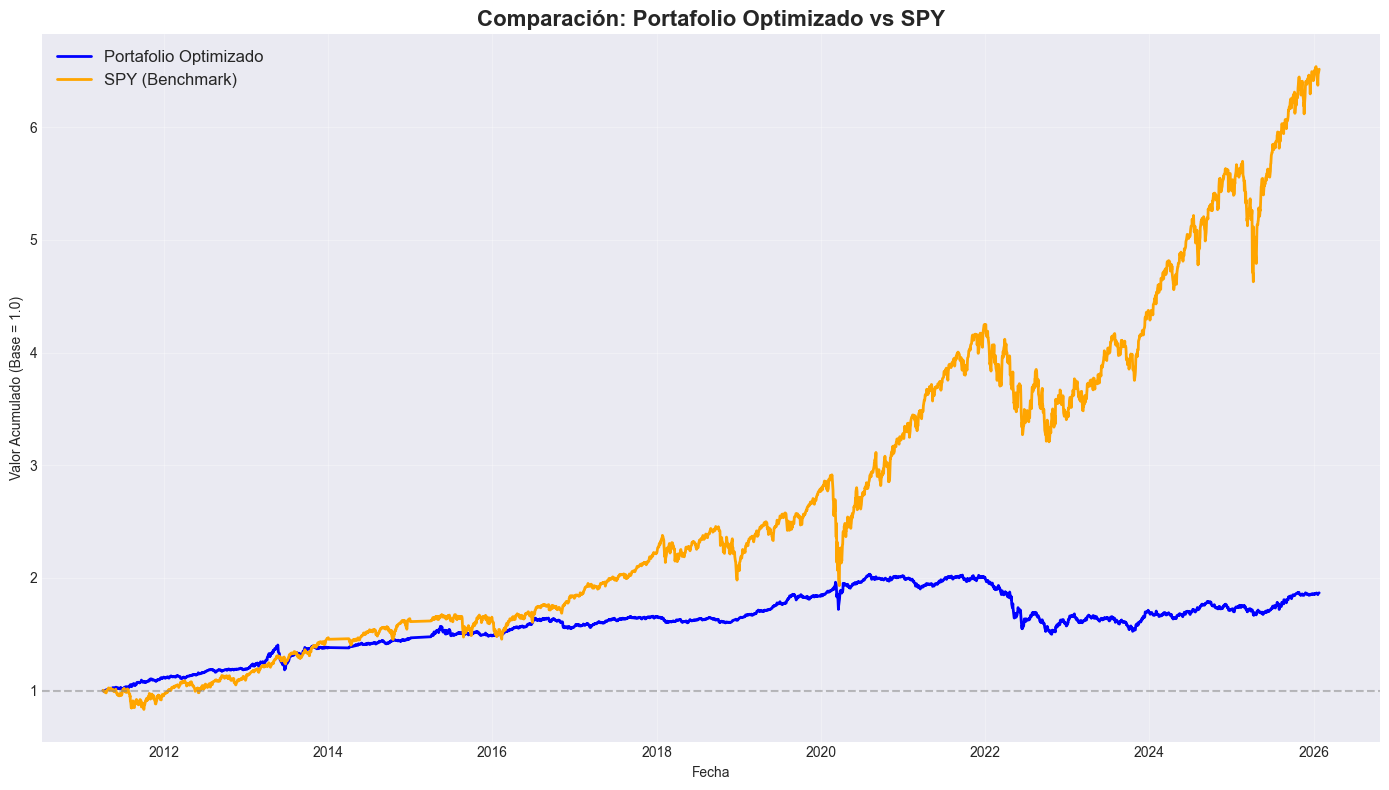


Comparación de Retorno Total:
  Portafolio Optimizado: 86.83%
  SPY:                    551.31%
  Diferencia:             -464.48%

Comparación de Sharpe Ratio:
  Portafolio Optimizado: 0.5485
  SPY:                    0.8419
  Diferencia:             -0.2934


In [19]:
# Comparación con SPY
try:
    with open(os.path.join(data_dir, 'etf_returns_dict.pkl'), 'rb') as f:
        returns_dict = pickle.load(f)
    
    if 'SPY' in returns_dict:
        spy_returns = returns_dict['SPY']
        
        # Normalizar índices
        if isinstance(spy_returns.index, pd.DatetimeIndex):
            if spy_returns.index.tz is not None:
                spy_returns.index = spy_returns.index.tz_localize(None)
            spy_returns.index = spy_returns.index.normalize()
        
        # Alinear fechas
        common_dates = portfolio_returns.index.intersection(spy_returns.index)
        if len(common_dates) > 0:
            portfolio_aligned = portfolio_returns.loc[common_dates]
            spy_aligned = spy_returns.loc[common_dates]
            
            # Calcular valores acumulados
            portfolio_cum = (1 + portfolio_aligned / 100).cumprod()
            spy_cum = (1 + spy_aligned / 100).cumprod()
            
            fig, ax = plt.subplots(figsize=(14, 8))
            ax.plot(portfolio_cum.index, portfolio_cum.values, linewidth=2, 
                   label='Portafolio Optimizado', color='blue')
            ax.plot(spy_cum.index, spy_cum.values, linewidth=2, 
                   label='SPY (Benchmark)', color='orange')
            ax.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)
            ax.set_title('Comparación: Portafolio Optimizado vs SPY', 
                       fontsize=16, fontweight='bold')
            ax.set_xlabel('Fecha')
            ax.set_ylabel('Valor Acumulado (Base = 1.0)')
            ax.legend(fontsize=12)
            ax.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.savefig(os.path.join(data_dir, 'visualizations', 'comparison_vs_spy.png'), 
                      dpi=300, bbox_inches='tight')
            plt.show()
            
            # Calcular métricas comparativas
            portfolio_total = portfolio_cum.iloc[-1] - 1
            spy_total = spy_cum.iloc[-1] - 1
            
            print(f"\nComparación de Retorno Total:")
            print(f"  Portafolio Optimizado: {portfolio_total*100:.2f}%")
            print(f"  SPY:                    {spy_total*100:.2f}%")
            print(f"  Diferencia:             {(portfolio_total - spy_total)*100:.2f}%")
            
            # Calcular Sharpe de ambos
            portfolio_sharpe = portfolio_metrics['sharpe_ratio']
            spy_annualized = spy_aligned.mean() * 252
            spy_vol = spy_aligned.std() * np.sqrt(252)
            spy_sharpe = (spy_annualized - 0.02) / spy_vol if spy_vol > 0 else 0
            
            print(f"\nComparación de Sharpe Ratio:")
            print(f"  Portafolio Optimizado: {portfolio_sharpe:.4f}")
            print(f"  SPY:                    {spy_sharpe:.4f}")
            print(f"  Diferencia:             {portfolio_sharpe - spy_sharpe:.4f}")
except Exception as e:
    print(f"[WARNING] No se pudo generar comparación con SPY: {e}")

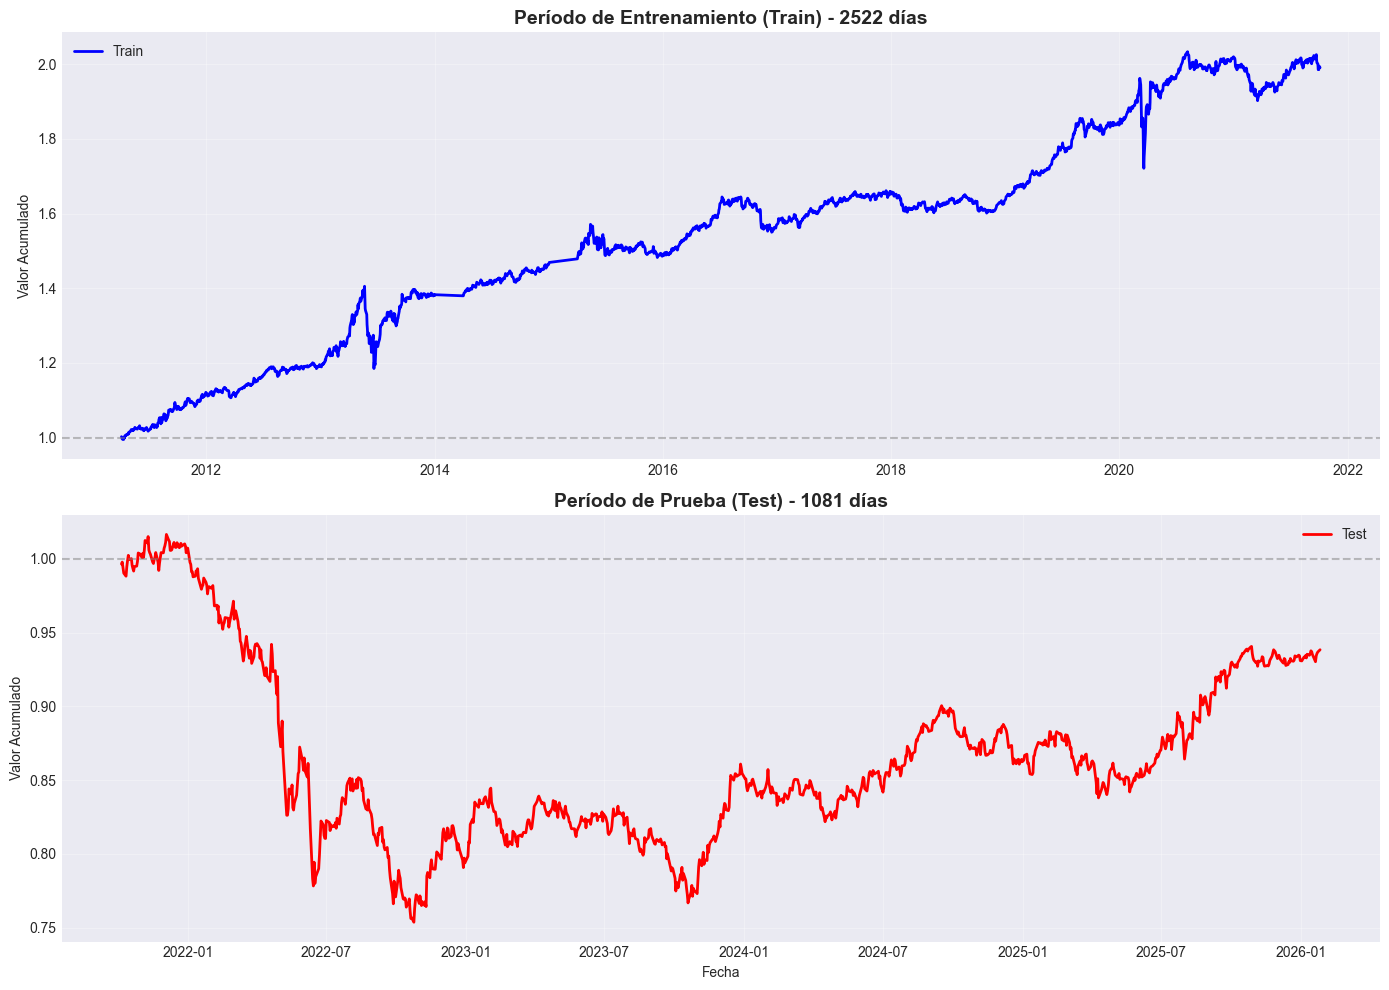


Métricas Train:
  Retorno Anualizado: 7.12%
  Sharpe Ratio: 1.1045
  Volatilidad: 6.45%

Métricas Test:
  Retorno Anualizado: -1.47%
  Sharpe Ratio: -0.1600
  Volatilidad: 9.20%

[OK] Gráfico train/test guardado


In [20]:
# División Train/Test
split_idx = int(len(portfolio_returns) * 0.7)
train_returns = portfolio_returns.iloc[:split_idx]
test_returns = portfolio_returns.iloc[split_idx:]

train_cum = (1 + train_returns / 100).cumprod()
test_cum = (1 + test_returns / 100).cumprod()

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Train
ax1 = axes[0]
ax1.plot(train_cum.index, train_cum.values, linewidth=2, color='blue', label='Train')
ax1.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)
ax1.set_title(f'Período de Entrenamiento (Train) - {len(train_returns)} días', 
             fontsize=14, fontweight='bold')
ax1.set_ylabel('Valor Acumulado')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Test
ax2 = axes[1]
ax2.plot(test_cum.index, test_cum.values, linewidth=2, color='red', label='Test')
ax2.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)
ax2.set_title(f'Período de Prueba (Test) - {len(test_returns)} días', 
             fontsize=14, fontweight='bold')
ax2.set_xlabel('Fecha')
ax2.set_ylabel('Valor Acumulado')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(data_dir, 'visualizations', 'train_test_split.png'), 
           dpi=300, bbox_inches='tight')
plt.show()

# Calcular métricas por período
def calculate_simple_metrics(returns):
    returns_pct = returns
    cumulative = (1 + returns_pct / 100).cumprod()
    total_return = cumulative.iloc[-1] - 1
    years = len(returns) / 252
    annualized = (1 + total_return) ** (1 / years) - 1 if years > 0 else 0
    volatility = returns_pct.std() * np.sqrt(252)
    sharpe = (annualized * 100) / volatility if volatility > 0 else 0
    return {'annualized_return': annualized, 'volatility': volatility, 'sharpe_ratio': sharpe}

train_metrics = calculate_simple_metrics(train_returns)
test_metrics = calculate_simple_metrics(test_returns)

print(f"\nMétricas Train:")
print(f"  Retorno Anualizado: {train_metrics['annualized_return']*100:.2f}%")
print(f"  Sharpe Ratio: {train_metrics['sharpe_ratio']:.4f}")
print(f"  Volatilidad: {train_metrics['volatility']:.2f}%")

print(f"\nMétricas Test:")
print(f"  Retorno Anualizado: {test_metrics['annualized_return']*100:.2f}%")
print(f"  Sharpe Ratio: {test_metrics['sharpe_ratio']:.4f}")
print(f"  Volatilidad: {test_metrics['volatility']:.2f}%")

print(f"\n[OK] Gráfico train/test guardado")

## Paso 9: Resumen Final

In [21]:
# Resumen final del pipeline
print("=" * 80)
print("RESUMEN FINAL DEL PIPELINE")
print("=" * 80)

print("\n✅ Pasos completados:")
print("  1. ✅ Descarga de datos de ETFs")
print("  2. ✅ Generación de features ML")
print("  3. ✅ Entrenamiento de modelos")
print("  4. ✅ Optimización de portafolio")
print("  5. ✅ Backtesting completo")
print("  6. ✅ Visualizaciones")

print("\n📊 Archivos generados:")
print(f"  - Datos: {data_dir}/etf_returns_dict.pkl")
print(f"  - Dataset ML: {data_dir}/ml_dataset.pkl")
print(f"  - Modelos: {models_dir}/sharpe_predictor_*.pkl")
print(f"  - Ensembles: {models_dir}/ensemble_*.pkl")
print(f"  - Resultados backtest: {data_dir}/backtest_results.pkl")
print(f"  - Visualizaciones: {data_dir}/visualizations/")

print("\n🎯 Estrategias implementadas:")
print("  - Feature selection (50 features)")
print("  - Regularización mejorada")
print("  - Ensemble de modelos")
print("  - Restricciones de riesgo")
print("  - Turnover constraint")
print("  - Stop-loss")
print("  - Re-balanceo conservador")
print("  - Gestión de riesgo dinámica (VIX)")

print("\n📈 Próximos pasos:")
print("  - Re-entrenar modelos periódicamente (cada 6-12 meses)")
print("  - Monitorear performance en tiempo real")
print("  - Ajustar parámetros según resultados")
print("  - Implementar en producción con paper trading primero")

print("\n" + "=" * 80)
print("PIPELINE COMPLETADO EXITOSAMENTE")
print("=" * 80)

RESUMEN FINAL DEL PIPELINE

✅ Pasos completados:
  1. ✅ Descarga de datos de ETFs
  2. ✅ Generación de features ML
  3. ✅ Entrenamiento de modelos
  4. ✅ Optimización de portafolio
  5. ✅ Backtesting completo
  6. ✅ Visualizaciones

📊 Archivos generados:
  - Datos: data/etf_returns_dict.pkl
  - Dataset ML: data/ml_dataset.pkl
  - Modelos: models/sharpe_predictor_*.pkl
  - Ensembles: models/ensemble_*.pkl
  - Resultados backtest: data/backtest_results.pkl
  - Visualizaciones: data/visualizations/

🎯 Estrategias implementadas:
  - Feature selection (50 features)
  - Regularización mejorada
  - Ensemble de modelos
  - Restricciones de riesgo
  - Turnover constraint
  - Stop-loss
  - Re-balanceo conservador
  - Gestión de riesgo dinámica (VIX)

📈 Próximos pasos:
  - Re-entrenar modelos periódicamente (cada 6-12 meses)
  - Monitorear performance en tiempo real
  - Ajustar parámetros según resultados
  - Implementar en producción con paper trading primero

PIPELINE COMPLETADO EXITOSAMENTE
